In [1]:
# Import all the necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import math
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import roc_curve, auc, f1_score, log_loss, accuracy_score,roc_auc_score,log_loss,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Read and preprocess cholera case data in Haiti.
WorldCholeraData = pd.read_csv(r'/content/Cholera_Datasets/WorldCholeraData.csv')
print(WorldCholeraData.head(10))
print(WorldCholeraData.info())


       Country  Year Number of reported cases of cholera  \
0  Afghanistan  2016                                 677   
1  Afghanistan  2015                               58064   
2  Afghanistan  2014                               45481   
3  Afghanistan  2013                                3957   
4  Afghanistan  2012                                  12   
5  Afghanistan  2011                                3733   
6  Afghanistan  2010                                2369   
7  Afghanistan  2009                                 662   
8  Afghanistan  2008                                4384   
9  Afghanistan  2005                                  33   

  Number of reported deaths from cholera Cholera case fatality rate  \
0                                      5                        0.7   
1                                      8                       0.01   
2                                      4                          0   
3                                     14               

In [3]:
# Data Cleaning
# Find null values in WorldCholeraData
WorldCholeraData.isnull().sum()

Country                                     0
Year                                        0
Number of reported cases of cholera        22
Number of reported deaths from cholera    117
Cholera case fatality rate                127
WHO Region                                  0
dtype: int64

In [4]:
# Found space in the data which is recorded as a string value. Remove spaces from the strings and convert to numeric.
WorldCholeraData['Number of reported cases of cholera'] = pd.to_numeric(WorldCholeraData['Number of reported cases of cholera'].str.replace(' ', ''), errors='coerce')

# Fill the null values in WorldCholeraData with 0
WorldCholeraData = WorldCholeraData.fillna(0)
WorldCholeraData.isnull().sum()

Country                                   0
Year                                      0
Number of reported cases of cholera       0
Number of reported deaths from cholera    0
Cholera case fatality rate                0
WHO Region                                0
dtype: int64

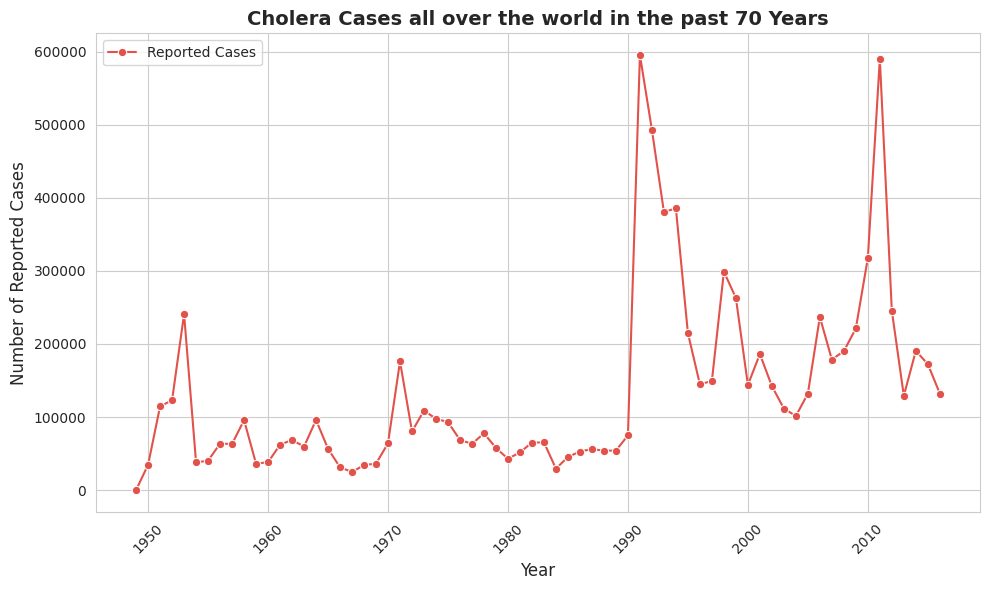

In [5]:
# Visualize the cholera cases count against the year all over the world with the help of line plot in seaborn
WorldCholeraData_WholeYear = WorldCholeraData.groupby('Year')['Number of reported cases of cholera'].sum()
sns.set_style("whitegrid")
sns.set_palette("Spectral")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=WorldCholeraData_WholeYear, marker='o')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reported Cases', fontsize=12)
plt.title('Cholera Cases all over the world in the past 70 Years', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend(['Reported Cases'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

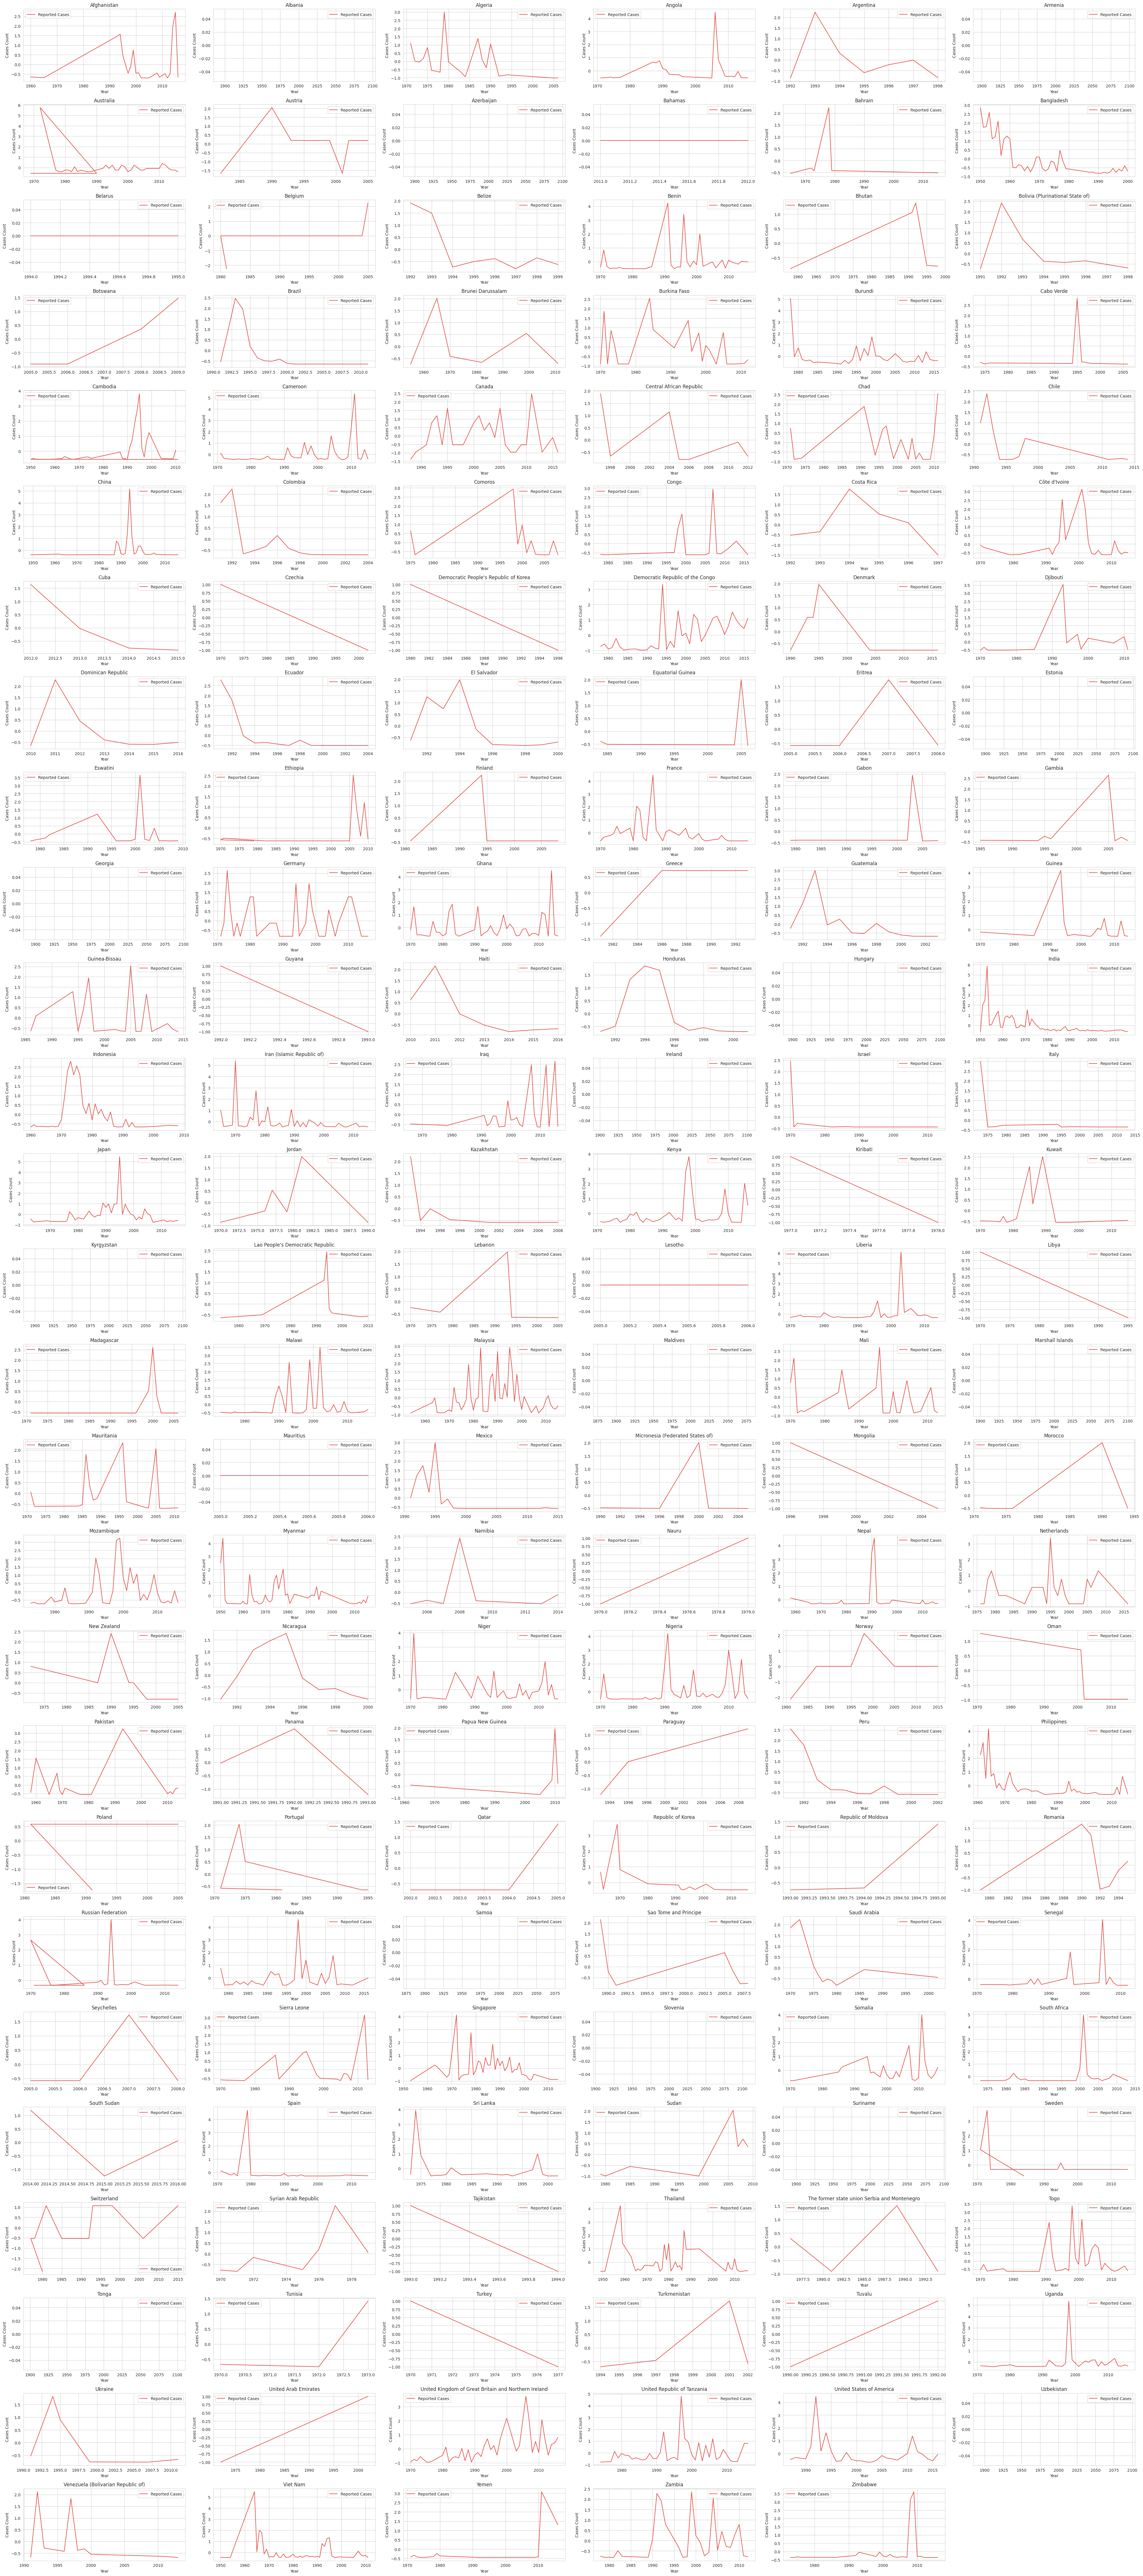

In [6]:
# Plot the graph showing cases count in each country seperately.
fig = plt.figure(figsize = (40,90))
scaler = StandardScaler()
for country,num in zip(WorldCholeraData.Country.unique(), np.arange(1,len(WorldCholeraData.Country.unique()))):
    WorldCholeraData_req = WorldCholeraData[WorldCholeraData['Country'] == country]
    ax = fig.add_subplot(27,6,num)
    x = WorldCholeraData_req['Year']
    y = WorldCholeraData_req['Number of reported cases of cholera']
    y_reshaped = y.values.reshape(-1, 1)
    #scale the data
    y_scaled = scaler.fit_transform(y_reshaped)
    y_scaled_flat = y_scaled.flatten()
    ax.plot(x,y_scaled_flat)
    ax.legend(['Reported Cases'])
    ax.set_title(country)
    ax.set_xlabel('Year')
    ax.set_ylabel('Cases Count')

plt.tight_layout()
plt.show()

Number of Cholera Cases Reported :
                                 Country     Count
0                           Afghanistan  263843.0
1                               Albania     626.0
2                               Algeria   12729.0
3                               Andorra       0.0
4                                Angola  191036.0
..                                  ...       ...
157  Venezuela (Bolivarian Republic of)    6969.0
158                            Viet Nam   73128.0
159                               Yemen   52462.0
160                              Zambia   97606.0
161                            Zimbabwe  153428.0

[162 rows x 2 columns]


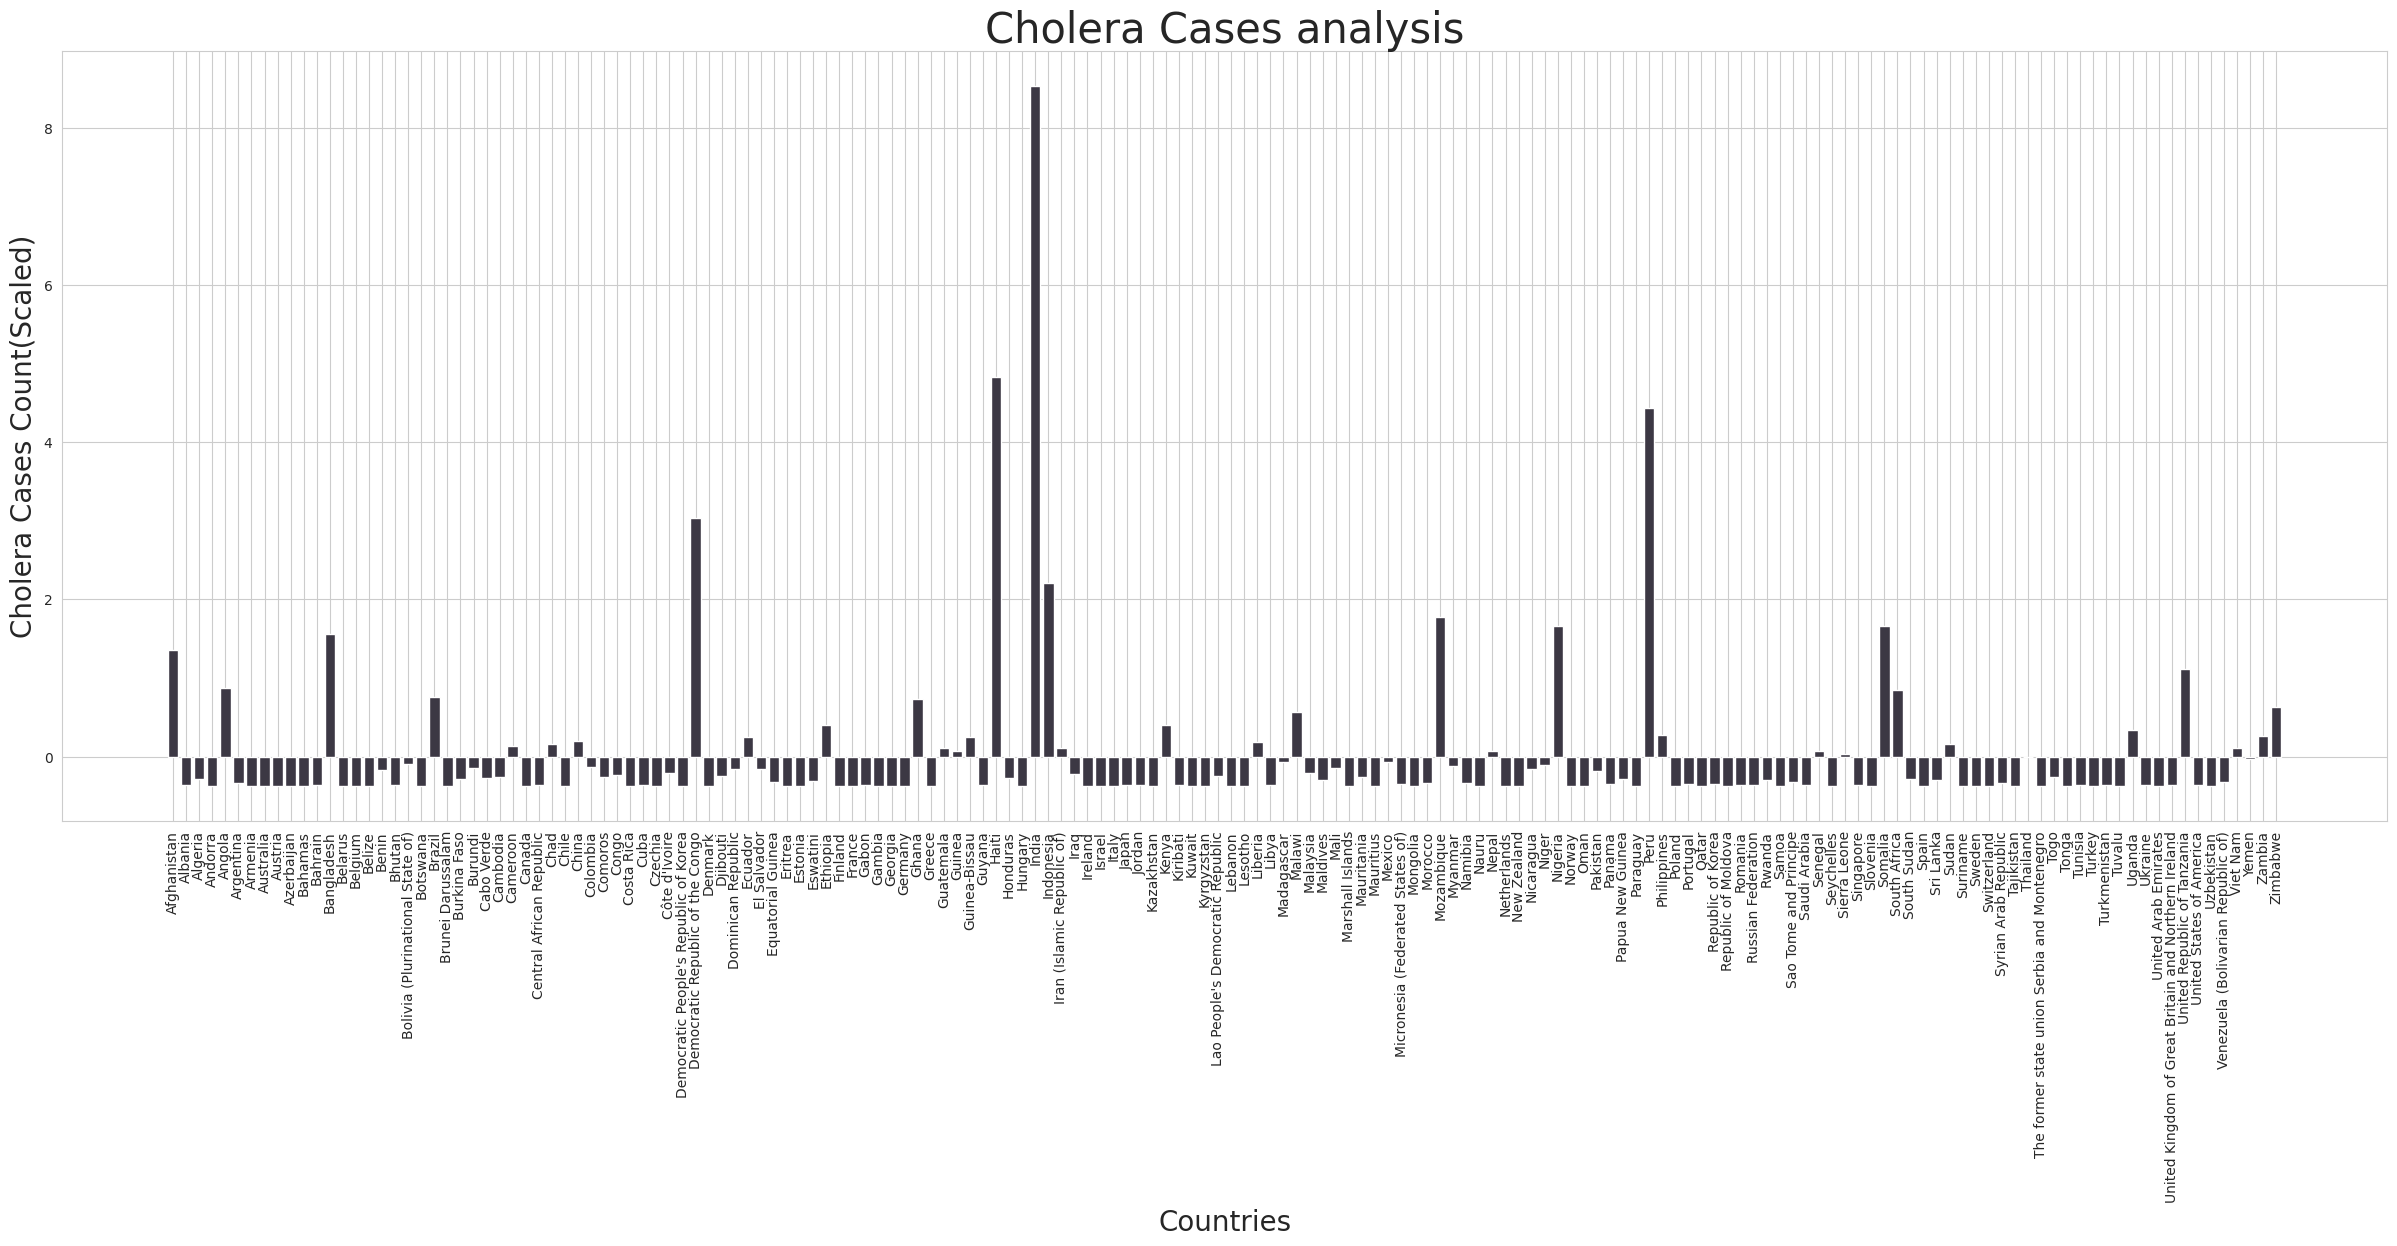

In [7]:
# Assign the 'Number of reported cases of cholera' values to the variable y and visualize the total number of cases recorded in the world.

CholeraCountryCaseCount = WorldCholeraData.groupby(['Country']).apply(lambda x:np.sum(pd.to_numeric(x['Number of reported cases of cholera']))).reset_index(name='Count')
print('Number of Cholera Cases Reported :\n',CholeraCountryCaseCount)

#scale the data
y = CholeraCountryCaseCount['Count']
y_reshaped = y.values.reshape(-1, 1)
y_scaled = scaler.fit_transform(y_reshaped)
y_scaled_flat = y_scaled.flatten()

# plot the figure
plt.figure(figsize=(30,10))
plt.bar(CholeraCountryCaseCount['Country'],y_scaled_flat,color='#3C3844')
plt.xlabel('Countries',size=20)
plt.ylabel('Cholera Cases Count(Scaled)',size=20)
plt.title('Cholera Cases analysis',size=30)
plt.xticks(rotation=90)
plt.show()

In [8]:
# For the prediction and analysis take the last 10 year data from the dataset.
WorldCholeraData_years = WorldCholeraData.Year.unique()
WorldCholeraData_years.sort()
Last_10_years = WorldCholeraData_years[-10:]
Last_10_years

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [9]:
Last10_years_case = WorldCholeraData[WorldCholeraData['Year'].isin(Last_10_years)]
WorldCholeraData_yr_ctry = Last10_years_case.groupby(['Country']).apply(lambda x:np.sum(pd.to_numeric(x['Number of reported cases of cholera']))).reset_index(name='Number of reported cases of cholera')
MostCholeraCases = WorldCholeraData_yr_ctry.sort_values('Number of reported cases of cholera', ascending = False)[0:10].reset_index(drop=True)
print('Countries with the highest cholera case counts over the past decade: \n\n',MostCholeraCases)

Countries with the highest cholera case counts over the past decade: 

                             Country  Number of reported cases of cholera
0                             Haiti                             795794.0
1  Democratic Republic of the Congo                             246985.0
2                           Somalia                             179693.0
3                           Nigeria                             137846.0
4                          Zimbabwe                             130537.0
5                       Afghanistan                             119339.0
6                          Ethiopia                              61174.0
7                             Ghana                              53171.0
8                        Mozambique                              52715.0
9                             Yemen                              47895.0


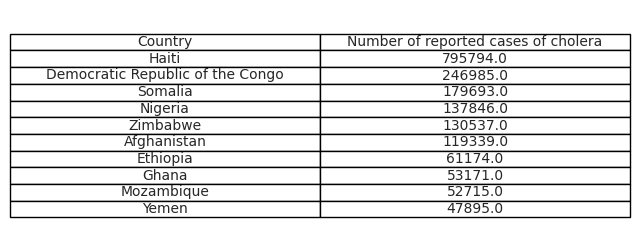

In [10]:
# Plot the DataFrame as a table
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=MostCholeraCases.values, colLabels=MostCholeraCases.columns, cellLoc='center', loc='center')

# Save the plot as an image
plt.savefig(r'/content/Cholera_Datasets/HighestCasesTable.png', bbox_inches='tight', dpi=300)
plt.show()

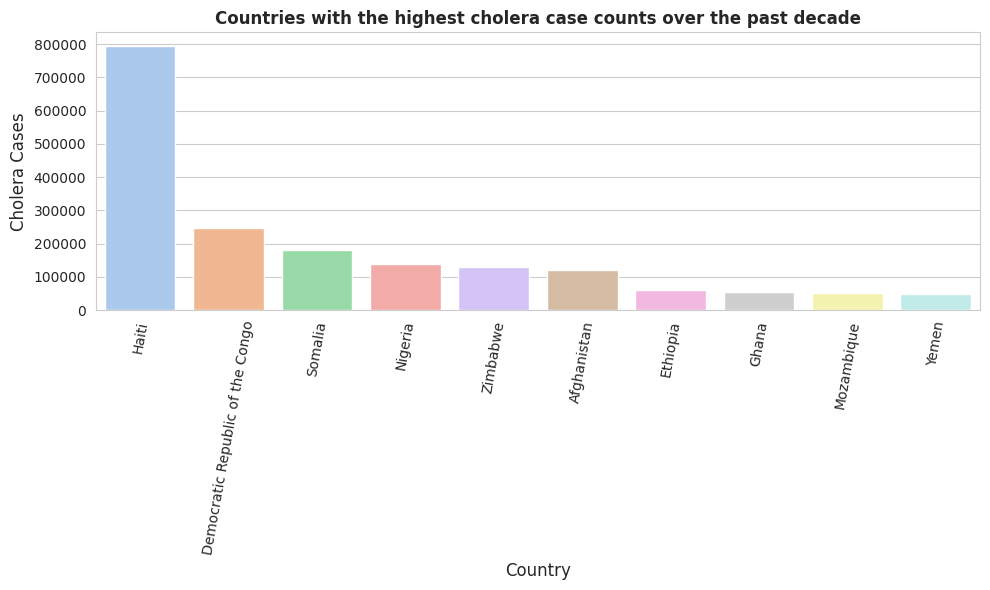

In [11]:
# Visualize the result with the help of seaborn bar plot
# Sort the DataFrame by 'Number of reported cases of cholera' in descending order
df_sorted = MostCholeraCases.sort_values(by='Number of reported cases of cholera', ascending=False)

sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_sorted, x='Country', y='Number of reported cases of cholera')
plt.xlabel('Country', size=12)
plt.ylabel('Cholera Cases', size=12)
plt.title('Countries with the highest cholera case counts over the past decade', size=12, fontweight='bold')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


In [12]:
# Based on the latest visualization, it is evident that Haiti has reported the highest number of cholera cases,
# making it the country with the highest case count.

# Read and preprocess cholera case data in Haiti.
CholeraCasedata = pd.read_excel(r'/content/Cholera_Datasets/HaitiCholeraCases.xlsx')
print(CholeraCasedata.info())
# Define a dictionary to map French month abbreviations to numbers.
month_mapping = {
    'jan': '01',
    'fev': '02',
    'mars': '03',
    'avr': '04',
    'mai': '05',
    'juin': '06',
    'juil': '07',
    'aou': '08',
    'sep': '09',
    'oct': '10',
    'nov': '11',
    'dec': '12'
}

# Replace month abbreviations in the 'Month' column using the mapping dictionary
CholeraCasedata['Month'] = CholeraCasedata['Month'].replace(month_mapping, regex=True)

# Convert 'Month' column to datetime format
CholeraCasedata['Month'] = pd.to_datetime(CholeraCasedata['Month'])

# Make the 'Month' column uniform in date format (extracting only month and year)
CholeraCasedata['Month'] = CholeraCasedata['Month'].dt.to_period('M')
CholeraCasedata.sort_values(by='Month')

# Define the start and end dates for the date range
start_date = '2011-01'
end_date = '2016-03'

# Select rows where the 'Month' column is within the date range
mask = (CholeraCasedata['Month'] >= start_date) & (CholeraCasedata['Month'] <= end_date)
Cholera_Case_data = CholeraCasedata.loc[mask]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Month           66 non-null     object
 1   Monthly deaths  66 non-null     int64 
 2   Monthly cases   66 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.7+ KB
None


In [13]:
# Check for null values
nan_counts = Cholera_Case_data.isnull().sum()
nan_counts

Month             0
Monthly deaths    0
Monthly cases     0
dtype: int64

In [14]:
# Read and pre process mean temperature data
TemperatureData = pd.read_csv(r'/content/Cholera_Datasets/MeanTemperatureHaiti.csv',delimiter=',',skiprows =2)
print(TemperatureData.info())
TemperatureData = TemperatureData.rename(columns={'Unnamed: 0': 'Year'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  121 non-null    int64  
 1   Jan         121 non-null    float64
 2   Feb         121 non-null    float64
 3   Mar         121 non-null    float64
 4   Apr         121 non-null    float64
 5   May         121 non-null    float64
 6   Jun         121 non-null    float64
 7   Jul         121 non-null    float64
 8   Aug         121 non-null    float64
 9   Sep         121 non-null    float64
 10  Oct         121 non-null    float64
 11  Nov         121 non-null    float64
 12  Dec         121 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 12.4 KB
None


In [15]:
# Select rows within the specific date range
TemperatureData = TemperatureData[(TemperatureData['Year'] >= 2011) & (TemperatureData['Year'] <= 2016)]

In [16]:
TemperatureData_melted = pd.melt(TemperatureData, id_vars=['Year'], var_name='Months', value_name='Mean Temperature')
TemperatureData_melted['Month'] = pd.to_datetime(TemperatureData_melted['Year'].astype(str) + TemperatureData_melted['Months'], format='%Y%b')
TemperatureData_melted['Month'] = TemperatureData_melted['Month'].dt.to_period('M')

In [17]:
TemperatureData_melted = TemperatureData_melted.sort_values(by='Month')

In [18]:
Mean_TemperatureData = TemperatureData_melted

In [19]:
# Check for null values
nan_counts = Mean_TemperatureData.isnull().sum()
nan_counts

Year                0
Months              0
Mean Temperature    0
Month               0
dtype: int64

In [20]:
# Merge the Mean Temperature Data and Cholera Case data
merged_df = pd.merge(Cholera_Case_data, Mean_TemperatureData, on='Month', how='left')

In [21]:
# Read and pre process the Mean precipitation data
PrecipitationData = pd.read_csv(r'/content/Cholera_Datasets/MeanPrecipitationHaiti.csv',delimiter=',',skiprows =2)
PrecipitationData = PrecipitationData.rename(columns={'Unnamed: 0': 'Year'})

In [22]:
# Select rows within the specific date range
PrecipitationData = PrecipitationData[(PrecipitationData['Year'] >= 2011) & (PrecipitationData['Year'] <= 2016)]

In [23]:
PrecipitationData_melted = pd.melt(PrecipitationData, id_vars=['Year'], var_name='Months', value_name='Mean Precipitation')
PrecipitationData_melted['Month'] = pd.to_datetime(PrecipitationData_melted['Year'].astype(str) + PrecipitationData_melted['Months'], format='%Y%b')
PrecipitationData_melted['Month'] = PrecipitationData_melted['Month'].dt.to_period('M')

In [24]:
PrecipitationData_melted = PrecipitationData_melted.sort_values(by='Month')
PrecipitationData_melted = PrecipitationData_melted.drop(['Months', 'Year'], axis=1)

In [25]:
# Check for null values
nan_counts = PrecipitationData_melted.isnull().sum()
nan_counts

Mean Precipitation    0
Month                 0
dtype: int64

In [26]:
# Merge the precipitation dataframe with previous dataframe
merged_df = pd.merge(merged_df,PrecipitationData_melted, on='Month', how='left')


In [27]:
# Read and preprocess the maximum temperature in haiti data
MaxTemperatureData = pd.read_csv(r'/content/Cholera_Datasets/MaxTemperatureHaiti.csv',delimiter=',',skiprows =2)
MaxTemperatureData = MaxTemperatureData.rename(columns={'Unnamed: 0': 'Year'})

In [28]:
# Select rows within the specific date range
MaxTemperatureData = MaxTemperatureData[(MaxTemperatureData['Year'] >= 2011) & (MaxTemperatureData['Year'] <= 2016)]

In [29]:
MaxTemperatureData_melted = pd.melt(MaxTemperatureData, id_vars=['Year'], var_name='Months', value_name='Max Temperature')
MaxTemperatureData_melted['Month'] = pd.to_datetime(MaxTemperatureData_melted['Year'].astype(str) + MaxTemperatureData_melted['Months'], format='%Y%b')
MaxTemperatureData_melted['Month'] = MaxTemperatureData_melted['Month'].dt.to_period('M')

In [30]:
MaxTemperatureData_melted = MaxTemperatureData_melted.sort_values(by='Month')
MaxTemperatureData_melted = MaxTemperatureData_melted.drop(['Months', 'Year'], axis=1)


In [31]:
# Check for null values
nan_counts = MaxTemperatureData_melted.isnull().sum()
nan_counts

Max Temperature    0
Month              0
dtype: int64

In [32]:
#result =  pd.concat([Mean_TemperatureData, selected_rows])
merged_df = pd.merge(merged_df,MaxTemperatureData_melted, on='Month', how='left')

In [33]:
# Read and preprocess the Minimum temperature data in haiti
MinTemperatureData = pd.read_csv(r'/content/Cholera_Datasets/MinTemperatureHaiti.csv',delimiter=',',skiprows =2)
MinTemperatureData = MinTemperatureData.rename(columns={'Unnamed: 0': 'Year'})

In [34]:
# Select rows within the specific date range
MinTemperatureData = MinTemperatureData[(MinTemperatureData['Year'] >= 2011) & (MinTemperatureData['Year'] <= 2016)]

In [35]:
MinTemperatureData_melted = pd.melt(MinTemperatureData, id_vars=['Year'], var_name='Months', value_name='Min Temperature')
MinTemperatureData_melted['Month'] = pd.to_datetime(MinTemperatureData_melted['Year'].astype(str) + MinTemperatureData_melted['Months'], format='%Y%b')
MinTemperatureData_melted['Month'] = MinTemperatureData_melted['Month'].dt.to_period('M')

In [36]:
MinTemperatureData_melted = MinTemperatureData_melted.sort_values(by='Month')
MinTemperatureData_melted = MinTemperatureData_melted.drop(['Months', 'Year'], axis=1)

In [37]:
# Check for null values
nan_counts = MinTemperatureData_melted.isnull().sum()
nan_counts

Min Temperature    0
Month              0
dtype: int64

In [38]:
# merge the previous dataframe with minimum temperature dataframe
merged_df = pd.merge(merged_df,MinTemperatureData_melted, on='Month', how='left')

In [39]:
# Read and pre process the sanitation data
SanitationData = pd.read_csv(r'/content/Cholera_Datasets/indexes.csv',delimiter=',')
print(SanitationData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3463 entries, 0 to 3462
Data columns (total 22 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Year                                                                 3463 non-null   int64  
 1   Region                                                               3463 non-null   object 
 2   Country code                                                         3463 non-null   object 
 3   Country                                                              3463 non-null   object 
 4   Population using at least basic drinking-water services (%) - Rural  2953 non-null   float64
 5   Population using at least basic drinking-water services (%) - Total  3449 non-null   float64
 6   Population using at least basic drinking-water services (%) - Urban  3013 non-null   float64
 7   Popula

In [40]:
CompleteSanitationData = pd.DataFrame(SanitationData[(SanitationData['Country code'] == 'HTI')][['Year','Population using at least basic drinking-water services (%) - Total','Population using at least basic sanitation services (%) - Total','Population practising open defecation (%) - Total']])
df_CompleteSanitationData=CompleteSanitationData.reset_index(drop=True)
df_CompleteSanitationData

Year  Population using at least basic drinking-water services (%) - Total  \
0   2000                                           56.23929                     
1   2001                                           57.06076                     
2   2002                                           57.89031                     
3   2003                                           58.72479                     
4   2004                                           59.25749                     
5   2005                                           59.75303                     
6   2006                                           60.24738                     
7   2007                                           60.73926                     
8   2008                                           61.22998                     
9   2009                                           61.71658                     
10  2010                                           62.20079                     
11  2011                                           62.68180                     
12  2012                                           63.15966                     
13  2013                                           63.63269                     
14  2014                                           64.10223                     
15  2015                                           64.56748                     
16  2016                                           65.02302                     
17  2017                                           65.46683                     

    Population using at least basic sanitation services (%) - Total  \
0                                            16.74954                 
1                                            17.83750                 
2                                            18.93771                 
3                                            20.04967                 
4                                            21.05167                 
5                                            22.04754                 
6                                            23.05187                 
7                                            24.06454                 
8                                            25.08643                 
9                                            26.11670                 
10                                           27.15644                 
11                                           28.20566                 
12                                           29.26475                 
13                                           30.33333                 
14                                           31.41232                 
15                                           32.50173                 
16                                           33.59935                 
17                                           34.70445                 

    Population practising open defecation (%) - Total  
0                                            37.06716  
1                                            35.66333  
2                                            34.27816  
3                                            32.91534  
4                                            31.84075  
5                                            30.81366  
6                                            29.80252  
7                                            28.80857  
8                                            27.83091  
9                                            26.87206  
10                                           25.93073  
11                                           25.00765  
12                                           24.10289  
13                                           23.21767  
14                                           22.35109  
15                                           21.50371  
16                                           20.67893  
17                                           19.87759

In [41]:
# Check for null values
nan_counts = df_CompleteSanitationData.isnull().sum()
nan_counts

Year                                                                   0
Population using at least basic drinking-water services (%) - Total    0
Population using at least basic sanitation services (%) - Total        0
Population practising open defecation (%) - Total                      0
dtype: int64

In [42]:
# Merge the previous data frame with sanitation data
merged_df= pd.merge(merged_df,df_CompleteSanitationData, on='Year', how='left')

In [43]:
Total_df = merged_df

# print the total dataframe
print(Total_df)

      Month  Monthly deaths  Monthly cases  Year Months  Mean Temperature  \
0   2011-01             573          54710  2011    Jan             22.12   
1   2011-02             186          28372  2011    Feb             22.54   
2   2011-03             138          24993  2011    Mar             22.78   
3   2011-04             161          18835  2011    Apr             23.85   
4   2011-05             193          29785  2011    May             24.34   
..      ...             ...            ...   ...    ...               ...   
58  2015-11              63           4944  2015    Nov             25.34   
59  2015-12              26           5436  2015    Dec             24.75   
60  2016-01              60           5335  2016    Jan             23.25   
61  2016-02              35           3264  2016    Feb             23.78   
62  2016-03              34           3101  2016    Mar             24.54   

    Mean Precipitation  Max Temperature  Min Temperature  \
0              

In [44]:
# Create a function to insert new columns in the Total_df to find the difference between the sanitation data in each year.
def FindDifference(column_name, indicator):
    Total_df[column_name] = Total_df[indicator].diff()/12
    filtered_set = {x for x in Total_df[column_name] if not (math.isnan(x) or x == 0)}
    if(indicator!='Population practising open defecation (%) - Total'):
        Filtered_data=sorted(filtered_set)
    else:
        Filtered_data=sorted(filtered_set,reverse=True)
    return Filtered_data

Drinkingwater_services_Difference = FindDifference('Drinkingwater_services_Difference','Population using at least basic drinking-water services (%) - Total')
Sanitation_services_Difference = FindDifference('Sanitation_services_Difference','Population using at least basic sanitation services (%) - Total')
Opendefecation_Difference = FindDifference('Opendefecation_Difference','Population practising open defecation (%) - Total')

In [45]:
# Find out the initial sanitation values in each year.
Set_Year = set(Total_df['Year'])
def FindStartValues(indicator):
    StartValue_list =[]
    for i in Set_Year:
        StartValue_list.append(Total_df[(Total_df['Year']==i) & (Total_df['Months']=='Jan')][indicator].values[0])
    if(indicator!='Population practising open defecation (%) - Total'):
        StartValue_list=sorted(list(StartValue_list))
    else:
        StartValue_list=sorted(list(StartValue_list),reverse=True)
    return StartValue_list

StartValue_drinkingwater = FindStartValues('Population using at least basic drinking-water services (%) - Total')
StartValue_basicsanitation = FindStartValues('Population using at least basic sanitation services (%) - Total')
StartValue_opendefecation = FindStartValues('Population practising open defecation (%) - Total')

In [46]:
# Assign values to new columns
def assignValues(column_name,start_value,difference ):
    k=0
    j=0
    z=0
    for k in range(0,5):
        for j in range(0,12):
            Total_df.loc[z,column_name]=start_value[k]+(difference[k]*j)
            z=z+1
assignValues('Basic Drinking Water',StartValue_drinkingwater,Drinkingwater_services_Difference)
assignValues('Basic Sanitation',StartValue_basicsanitation,Sanitation_services_Difference)
assignValues('Open Defecation',StartValue_opendefecation,Opendefecation_Difference)
print(Total_df)

      Month  Monthly deaths  Monthly cases  Year Months  Mean Temperature  \
0   2011-01             573          54710  2011    Jan             22.12   
1   2011-02             186          28372  2011    Feb             22.54   
2   2011-03             138          24993  2011    Mar             22.78   
3   2011-04             161          18835  2011    Apr             23.85   
4   2011-05             193          29785  2011    May             24.34   
..      ...             ...            ...   ...    ...               ...   
58  2015-11              63           4944  2015    Nov             25.34   
59  2015-12              26           5436  2015    Dec             24.75   
60  2016-01              60           5335  2016    Jan             23.25   
61  2016-02              35           3264  2016    Feb             23.78   
62  2016-03              34           3101  2016    Mar             24.54   

    Mean Precipitation  Max Temperature  Min Temperature  \
0              

In [47]:
# Select the rows in Total_df for further processing
Total_df = Total_df[(Total_df['Year'] >= 2011) & (Total_df['Year'] <= 2015)]

In [48]:
Total_df

Month  Monthly deaths  Monthly cases  Year Months  Mean Temperature  \
0   2011-01             573          54710  2011    Jan             22.12   
1   2011-02             186          28372  2011    Feb             22.54   
2   2011-03             138          24993  2011    Mar             22.78   
3   2011-04             161          18835  2011    Apr             23.85   
4   2011-05             193          29785  2011    May             24.34   
5   2011-06             546          56352  2011    Jun             25.48   
6   2011-07             361          39207  2011    Jul             25.58   
7   2011-08             202          24924  2011    Aug             25.75   
8   2011-09             195          23253  2011    Sep             25.65   
9   2011-10             205          28135  2011    Oct             25.27   
10  2011-11             120          17023  2011    Nov             24.27   
11  2011-12              47           6250  2011    Dec             22.96   
12  2012-01               9           4367  2012    Jan             22.27   
13  2012-02              18           3186  2012    Feb             23.08   
14  2012-03              34           3279  2012    Mar             23.44   
15  2012-04              52           6026  2012    Apr             24.13   
16  2012-05             112          14338  2012    May             25.05   
17  2012-06             110           9942  2012    Jun             26.21   
18  2012-07              61           6673  2012    Jul             26.15   
19  2012-08              64           6001  2012    Aug             26.33   
20  2012-09              75           7621  2012    Sep             26.20   
21  2012-10             100          11830  2012    Oct             25.69   
22  2012-11             131          15238  2012    Nov             24.18   
23  2012-12             142          12853  2012    Dec             23.35   
24  2013-01              86           7257  2013    Jan             23.27   
25  2013-02              14           4332  2013    Feb             23.29   
26  2013-03              24           3433  2013    Mar             23.46   
27  2013-04              25           2654  2013    Apr             24.44   
28  2013-05              26           3435  2013    May             25.03   
29  2013-06              52           4206  2013    Jun             26.21   
30  2013-07              44           5147  2013    Jul             25.83   
31  2013-08              44           5329  2013    Aug             26.33   
32  2013-09              53           5995  2013    Sep             25.99   
33  2013-10              99           7162  2013    Oct             25.88   
34  2013-11              81           6962  2013    Nov             24.44   
35  2013-12              62           2593  2013    Dec             23.59   
36  2014-01              14           1629  2014    Jan             23.30   
37  2014-02               4           1259  2014    Feb             23.78   
38  2014-03              10            889  2014    Mar             24.01   
39  2014-04               4            866  2014    Apr             25.23   
40  2014-05               3            902  2014    May             24.86   
41  2014-06              14           1017  2014    Jun             26.56   
42  2014-07               7           1148  2014    Jul             26.72   
43  2014-08              13           1025  2014    Aug             26.56   
44  2014-09              28           1839  2014    Sep             26.18   
45  2014-10              52           4577  2014    Oct             25.80   
46  2014-11              95           6765  2014    Nov             24.82   
47  2014-12              53           5392  2014    Dec             23.73   
48  2015-01              36           4321  2015    Jan             23.48   
49  2015-02              46           4055  2015    Feb             23.48   
50  2015-03              22           3041  2015    Mar             24.32   
51

In [49]:
# Drop the unwanted columns
columns_to_drop = ['Population using at least basic drinking-water services (%) - Total',
                   'Population using at least basic sanitation services (%) - Total',
                   'Population practising open defecation (%) - Total',
                   'Drinkingwater_services_Difference', 'Sanitation_services_Difference',
                   'Opendefecation_Difference']
Total_df = Total_df.drop(columns=columns_to_drop)

In [50]:
# Count the null values in dataframe
nan_counts = Total_df.isnull().sum()
print(nan_counts)

# Fill the nan with 0
Total_df = Total_df.fillna(0)
print(Total_df)

Month                   0
Monthly deaths          0
Monthly cases           0
Year                    0
Months                  0
Mean Temperature        0
Mean Precipitation      0
Max Temperature         0
Min Temperature         0
Basic Drinking Water    0
Basic Sanitation        0
Open Defecation         0
dtype: int64
      Month  Monthly deaths  Monthly cases  Year Months  Mean Temperature  \
0   2011-01             573          54710  2011    Jan             22.12   
1   2011-02             186          28372  2011    Feb             22.54   
2   2011-03             138          24993  2011    Mar             22.78   
3   2011-04             161          18835  2011    Apr             23.85   
4   2011-05             193          29785  2011    May             24.34   
5   2011-06             546          56352  2011    Jun             25.48   
6   2011-07             361          39207  2011    Jul             25.58   
7   2011-08             202          24924  2011    Aug    

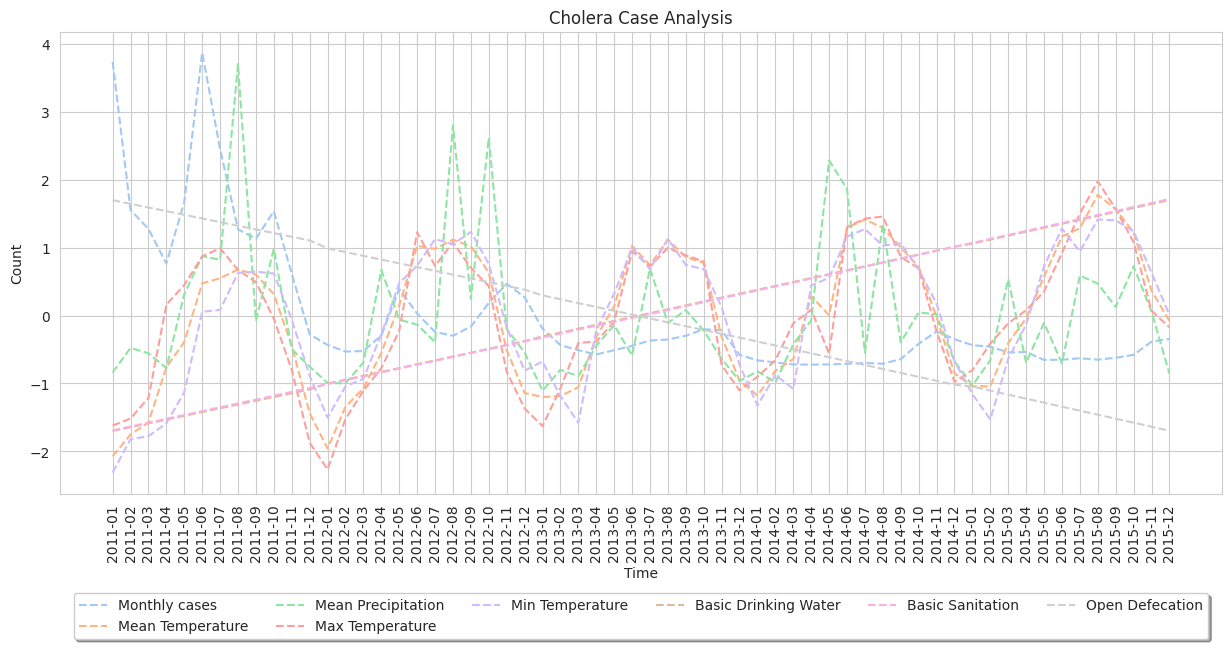

In [51]:
# A function to plot the cholera case analysis with the help of matplotlib
def linegraph(df, columns, xlabel, ylabel, title):
    df['Month'] = Total_df['Month'].dt.to_timestamp('s').dt.strftime('%Y-%m')
    x = df['Month']
    i = 0
    plt.figure(figsize=(15, 6))
    for y in range(0,len(columns)):
        plt.plot(x, df[y], linestyle = 'dashed', label = columns[y])
        i = i+1
    plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.2),
               fancybox = True, shadow = True, ncol = 6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

cols = ["Monthly cases","Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"]

#Scale data using StandarScaler()
scaler = StandardScaler()
df_data = scaler.fit_transform(Total_df[cols])
df_data = pd.DataFrame(df_data)
linegraph(df_data,cols,'Time','Count','Cholera Case Analysis')


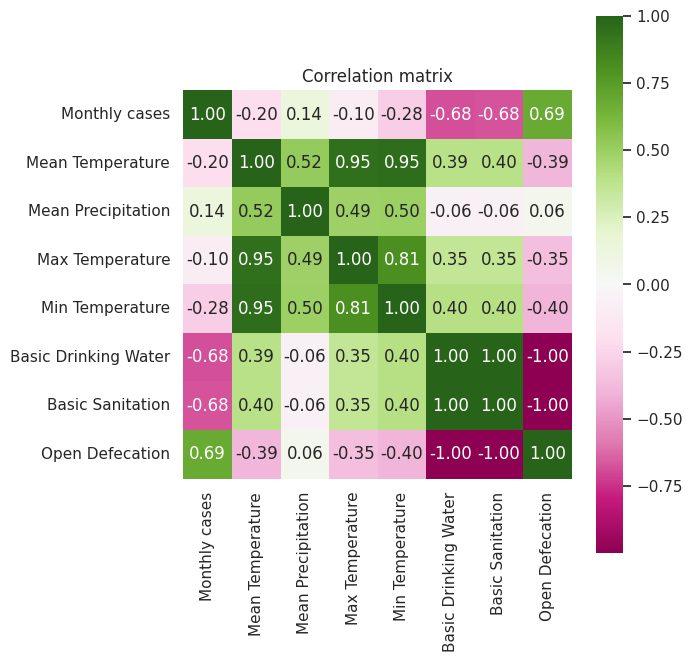

In [56]:
""" The correlation matrix displays how the features are correlated with each other with the help of seaborn heatmap."""

cols = ["Monthly cases","Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"]
stdsc = StandardScaler()
X_std = stdsc.fit_transform(Total_df[cols].iloc[:,range(0,8)].values)
corr_mat = np.corrcoef(X_std.T)
plt.figure(figsize = (7,7))
sns.set(font_scale = 1)
hm = sns.heatmap(corr_mat,
                 cbar = True,
                 annot = True,
                 square = True,
                 fmt = '.2f',
                 annot_kws = {'size': 12},
                 cmap = 'PiYG',
                 yticklabels = cols,
                 xticklabels = cols)
plt.title('Correlation matrix', size = 12)
plt.tight_layout()
plt.show()

In [67]:
# Experimenting with various classifiers to determine the most accurate one.
# Classifiers selected are : Gaussian process classifier, Logistic regression classifier,
# xgboost and Random forest classifier.

# Copy the data frame into a variable df
df = Total_df.copy()

# Create a binary target variable indicating whether the number of cases exceeds a threshold.
# threshold is set to 3000
threshold = 3000
df["Exceeded Threshold"] = (df["Monthly cases"] > threshold).astype(int)

# Separate features (X) and the new binary target (y)
X = df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"]]
y = df["Exceeded Threshold"]

In [68]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

# Scale the data using StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


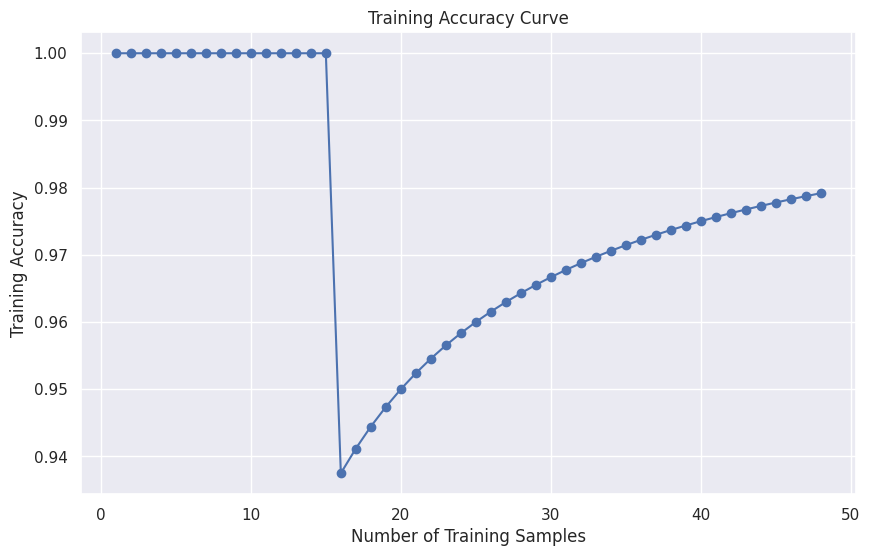

Training Accuracy 0.98


In [69]:
# 1. Gaussian Process Classifier
# Define the Gaussian Process Classifier
gp_classifier = GaussianProcessClassifier()

# Initialize lists to store training accuracies
training_accuracies = []
# Train the model using the entire training set and calculate accuracy for the first i samples
for i in range(1, len(X_train_scaled) + 1):
    gp_classifier.fit(X_train_scaled, y_train)  # Fit the model using the entire training set
    y_pred = gp_classifier.predict(X_train_scaled[:i])
    accuracy = accuracy_score(y_train[:i], y_pred)
    training_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_scaled) + 1), training_accuracies, marker='o')

plt.xlabel('Number of Training Samples')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.show()
print('Training Accuracy',np.round(accuracy,2))

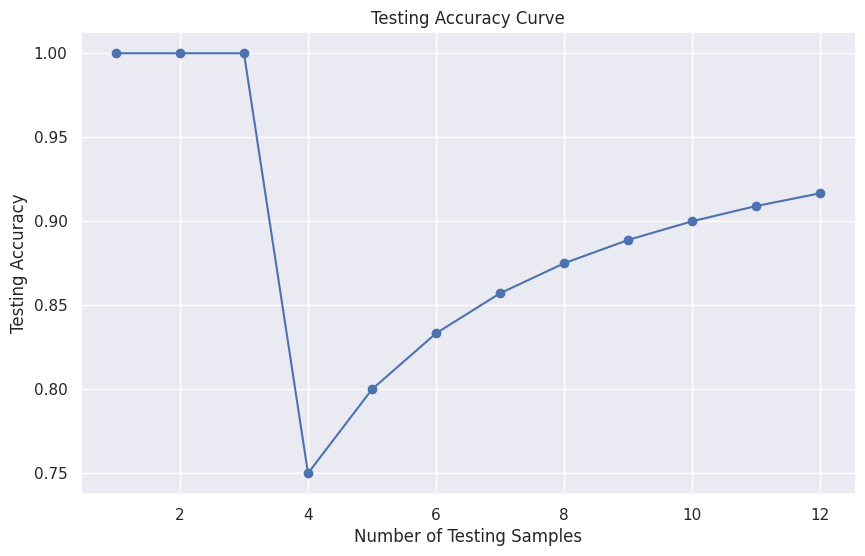

Log Loss: 0.54
Classification Report

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.89      0.94         9

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

ROC_AUC: 0.96


In [70]:
# Make predictions and evaluate the model
y_pred = gp_classifier.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = gp_classifier.predict_proba(X_test_scaled)

testing_accuracies= []
# Train the model using the entire training set and calculate accuracy for the first i samples
for i in range(1, len(y_test) + 1):
    accuracy = accuracy_score(y_test[:i], y_pred[:i])
    testing_accuracies.append(accuracy)

# Plot the testing accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test) + 1), testing_accuracies, marker='o')

plt.xlabel('Number of Testing Samples')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Curve')
plt.grid(True)
plt.show()

#log loss of the  model
logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

#roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print("ROC_AUC:", roc_auc)

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            1            8


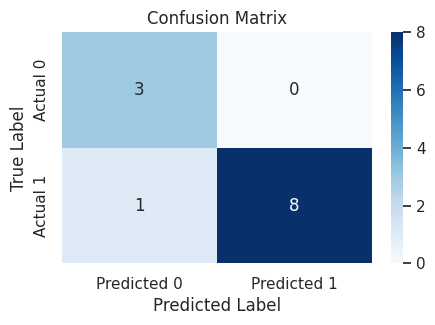

In [71]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [72]:
# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df

Outbreak Prediction Precentage  Predicted Label  True Label  \
0                            60.55                1           1   
1                            67.16                1           1   
2                            48.45                0           0   
3                            36.58                0           1   
4                            73.13                1           1   
5                            31.53                0           0   
6                            64.02                1           1   
7                            56.89                1           1   
8                            61.19                1           1   
9                            35.61                0           0   
10                           51.05                1           1   
11                           54.34                1           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [73]:
# Basic model
kernel = 1.0 * RBF(1.0)
gp_classifier = GaussianProcessClassifier(kernel =kernel,
                                             optimizer = 'fmin_l_bfgs_b',
                                             random_state=42,
                                             copy_X_train = True
                                             )


In [74]:
gp_classifier.fit(X_train_scaled, y_train)


GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1), random_state=42)

In [75]:
# Make predictions and evaluate the model
y_pred = gp_classifier.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = gp_classifier.predict_proba(X_test_scaled)

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy = np.round(accuracy, 2)
print("Accuracy:", accuracy,"\n")

# Loss of the model
logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

#roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print("ROC_AUC:", roc_auc)


Accuracy: 0.83 

Log Loss: 0.46
Classification Report

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.78      0.88         9

    accuracy                           0.83        12
   macro avg       0.80      0.89      0.81        12
weighted avg       0.90      0.83      0.84        12

ROC_AUC: 0.96


Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            2            7


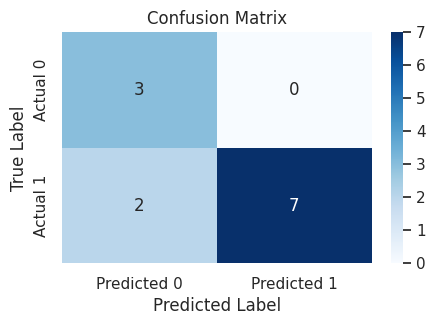

In [76]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [77]:
# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df

Outbreak Prediction Precentage  Predicted Label  True Label  \
0                            76.59                1           1   
1                            85.17                1           1   
2                            44.15                0           0   
3                            14.30                0           1   
4                            92.71                1           1   
5                            11.06                0           0   
6                            67.55                1           1   
7                            73.69                1           1   
8                            84.19                1           1   
9                            13.78                0           0   
10                           46.98                0           1   
11                           56.80                1           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [78]:
# Parameter tuning. Test out different values of n_restarts_optimizer.
param_dist = {'n_restarts_optimizer': randint(2, 15)}

In [79]:
model1 = GaussianProcessClassifier(kernel =kernel,
                                           optimizer = 'fmin_l_bfgs_b',
                                           random_state=42,
                                           copy_X_train = True
                                         )
Random_search_result = RandomizedSearchCV(estimator=model1,
                                    param_distributions=param_dist,
                                    n_iter=10,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)
#Result = optimal n_restarts_optimizer is 8
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'n_restarts_optimizer': 8}


In [81]:
#parameter tuning. Set n_restarts_optimizer to 8, look at max_iter_predict.
param_dist = {'max_iter_predict': randint(100, 150)}

In [82]:

model3 = GaussianProcessClassifier(kernel =kernel,
                                        optimizer = 'fmin_l_bfgs_b',
                                        n_restarts_optimizer =8,
                                        random_state=42,
                                        copy_X_train = True
                                        )

In [83]:
Random_search_result = RandomizedSearchCV(estimator=model3,
                                    param_distributions=param_dist,
                                    n_iter=10,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result = optimal max_iter_predict is 138.
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'max_iter_predict': 138}


In [84]:
#parameter tuning. Set n_restarts_optimizer to 8, look at max_iter_predict greater than 138
param_dist = {'max_iter_predict': randint(138, 200)}

In [85]:
model4 = GaussianProcessClassifier(kernel =kernel,
                                        optimizer = 'fmin_l_bfgs_b',
                                        n_restarts_optimizer =8,
                                        random_state=42,
                                        copy_X_train = True
                                        )

In [86]:
Random_search_result = RandomizedSearchCV(estimator=model4,
                                    param_distributions=param_dist,
                                    n_iter=10,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)
#Result = optimal max_iter_predict is 176.
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'max_iter_predict': 176}


In [87]:
#parameter tuning. Set n_restarts_optimizer to 8, look at max_iter_predict between 100 and 1000
param_dist = {'max_iter_predict': randint(100, 1000)}

In [88]:
model4 = GaussianProcessClassifier(kernel =kernel,
                                        optimizer = 'fmin_l_bfgs_b',
                                        n_restarts_optimizer =8,
                                        random_state=42,
                                        copy_X_train = True
                                        )

In [89]:
Random_search_result = RandomizedSearchCV(estimator=model4,
                                    param_distributions=param_dist,
                                    n_iter=10,  # Number of random combinations to try
                                    scoring='accuracy',
                                    cv=5,  # Cross-validation folds
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)
#Result = optimal max_iter_predict is 202.
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'max_iter_predict': 202}


In [90]:
#parameter tuning. Set n_restarts_optimizer to 8,max_iter_predict to 202, look at warm_start.
param_dist = {'warm_start': [True, False]}

In [91]:
model = GaussianProcessClassifier(kernel =kernel,
                                  optimizer = 'fmin_l_bfgs_b',
                                  n_restarts_optimizer =8,
                                  max_iter_predict = 202,
                                  random_state=42,
                                  copy_X_train = True
                                 )

In [92]:
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=2,  # Number of random combinations to try
                                    scoring='accuracy',
                                    cv=5,  # Cross-validation folds
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)
#Result = warm_start is True.
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'warm_start': True}


In [93]:
#parameter tuning. Set n_restarts_optimizer to 8,max_iter_predict to 202, warm_start to True, look at kernel
""" Small Length Scale (0.1), Moderate Length Scale (1.0)"""
#Define Kernel of scale 1.0
kernel = 1.0 * RBF(length_scale=1.0)

In [94]:
model = GaussianProcessClassifier(kernel =kernel,
                                  optimizer = 'fmin_l_bfgs_b',
                                  n_restarts_optimizer =8,
                                  max_iter_predict = 202,
                                  random_state=42,
                                  copy_X_train = True,
                                  warm_start = True
                                 )

In [95]:
# Fit the model to the data
model.fit(X_train_scaled, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=202, n_restarts_optimizer=8,
                          random_state=42, warm_start=True)

In [96]:

# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)


# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

#accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy = np.round(accuracy, 2)
print("Accuracy:", accuracy,"\n")

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

#roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print("ROC_AUC:", roc_auc)


Accuracy: 0.83 

Classification Report

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.78      0.88         9

    accuracy                           0.83        12
   macro avg       0.80      0.89      0.81        12
weighted avg       0.90      0.83      0.84        12

Log Loss: 0.46
ROC_AUC: 0.96


Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            2            7


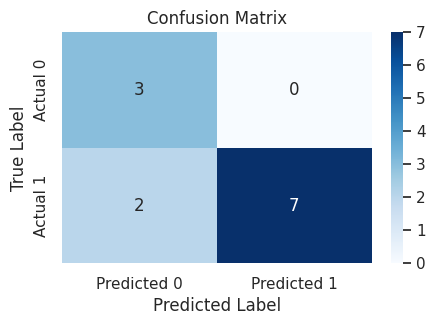

In [97]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.83 

Classification Report

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.78      0.88         9

    accuracy                           0.83        12
   macro avg       0.80      0.89      0.81        12
weighted avg       0.90      0.83      0.84        12

Log Loss: 0.46
ROC_AUC: 0.96
Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            2            7


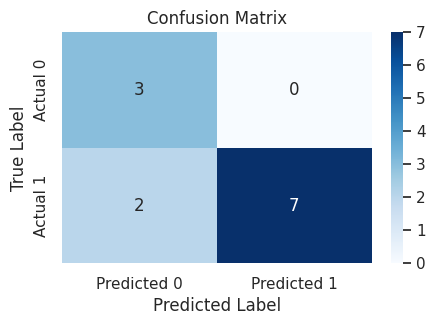

In [98]:
#Define Kernel of scale 0.1
kernel = 1.0 * RBF(length_scale=0.1)

model = GaussianProcessClassifier(kernel =kernel,
                                  optimizer = 'fmin_l_bfgs_b',
                                  n_restarts_optimizer =8,
                                  max_iter_predict = 202,
                                  random_state=42,
                                  copy_X_train = True,
                                  warm_start =True
                                 )
# Fit the model to the data
model.fit(X_train_scaled, y_train)


# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

#accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy = np.round(accuracy, 2)
print("Accuracy:", accuracy,"\n")

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

#roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print("ROC_AUC:", roc_auc)

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [86]:
#The consistent Classification Report across different kernel values suggests that the model's performance is relatively stable

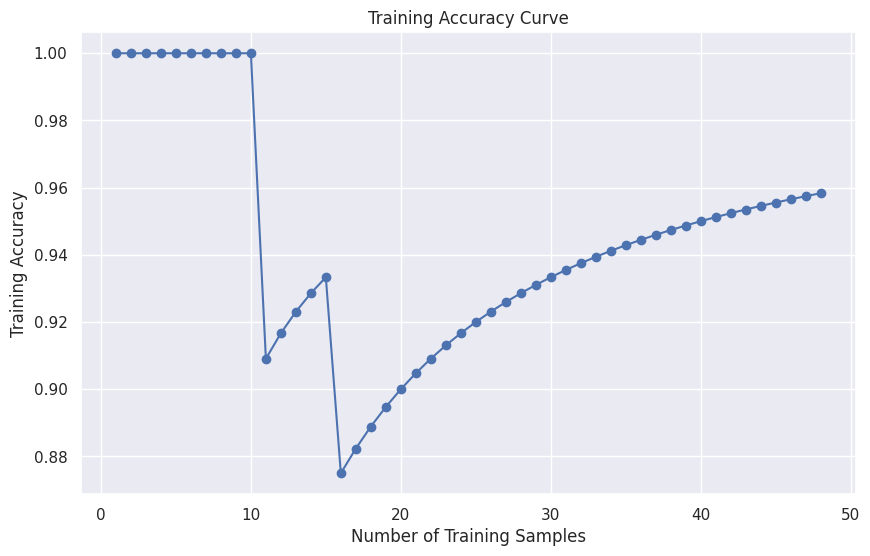

Training Accuracy 0.96


In [99]:
#Guassian process classifier after tuning the parameters
#define the kernel
kernel = 1.0 * RBF(length_scale=0.1)

# create the model
model = GaussianProcessClassifier(kernel =kernel,
                                  optimizer = 'fmin_l_bfgs_b',
                                  n_restarts_optimizer =8,
                                  max_iter_predict = 202,
                                  random_state=42,
                                  copy_X_train = True
                                 )

# Initialize lists to store training accuracies
training_accuracies = []
for i in range(1, len(X_train_scaled) + 1):
    model.fit(X_train_scaled, y_train)  # Fit the model using the entire training set
    y_pred = model.predict(X_train_scaled[:i])
    accuracy = accuracy_score(y_train[:i], y_pred)
    training_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_scaled) + 1), training_accuracies, marker='o')

plt.xlabel('Number of Training Samples')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.show()
print('Training Accuracy',np.round(accuracy,2))

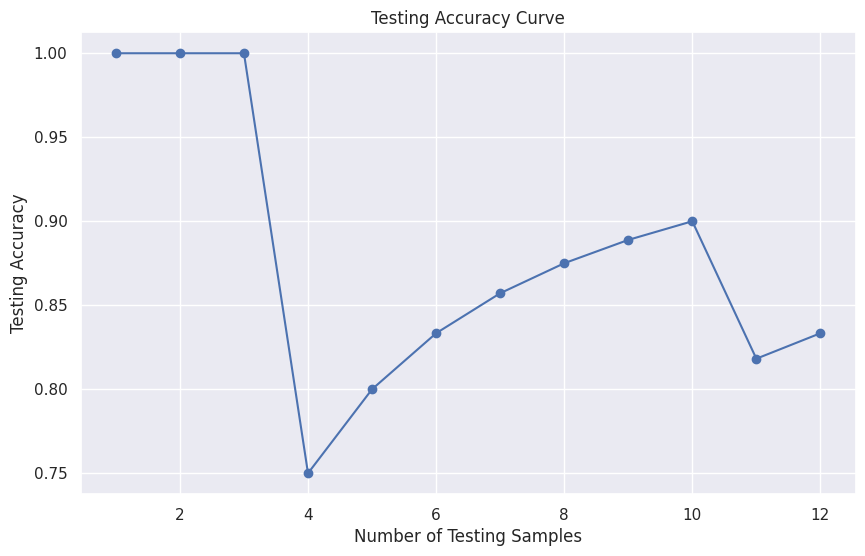

Log Loss: 0.46
ROC_AUC: 0.96
Classification Report

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.78      0.88         9

    accuracy                           0.83        12
   macro avg       0.80      0.89      0.81        12
weighted avg       0.90      0.83      0.84        12

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            2            7


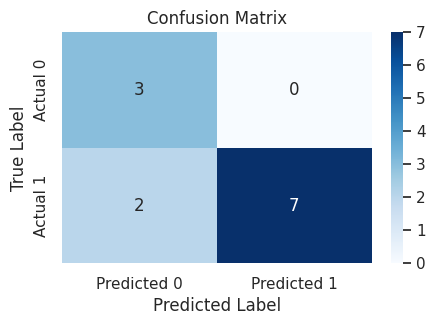

Outbreak Prediction Precentage  Predicted Label  True Label  \
0                            76.59                1           1   
1                            85.17                1           1   
2                            44.15                0           0   
3                            14.30                0           1   
4                            92.71                1           1   
5                            11.06                0           0   
6                            67.55                1           1   
7                            73.69                1           1   
8                            84.19                1           1   
9                            13.78                0           0   
10                           46.98                0           1   
11                           56.80                1           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [100]:
# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

testing_accuracies= []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(y_test) + 1):
    accuracy = accuracy_score(y_test[:i], y_pred[:i])
    testing_accuracies.append(accuracy)

# Plot the testing accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test) + 1), testing_accuracies, marker='o')

plt.xlabel('Number of Testing Samples')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Curve')
plt.grid(True)
plt.show()

logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

#roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print("ROC_AUC:", roc_auc)

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))


# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df

In [ ]:
#-----------------------------------------------------------------------------------


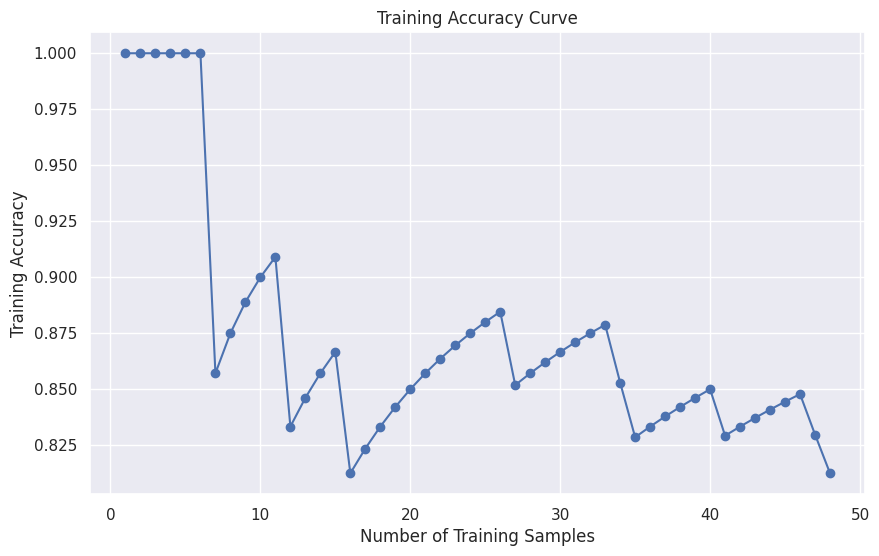

Training Accuracy 0.81


In [101]:
#logistic regression

# Load the dataset
data = Total_df.copy()

# Create a binary target variable indicating whether the number of cases exceeds a threshold (e.g., 1000)
threshold = 3000
df["Exceeded Threshold"] = (df["Monthly cases"] > threshold).astype(int)

# Separate features (X) and the new binary target (y)
X = df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"]]
y = df["Exceeded Threshold"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle =True)

# Scale the data using StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize the logistic regression model
model = LogisticRegression()

# Initialize lists to store training accuracies
training_accuracies = []
# Train the model using the entire training set and calculate accuracy for the first i samples
for i in range(1, len(X_train_scaled) + 1):
    model.fit(X_train_scaled, y_train)  # Fit the model using the entire training set
    y_pred = model.predict(X_train_scaled[:i])
    accuracy = accuracy_score(y_train[:i], y_pred)
    training_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_scaled) + 1), training_accuracies, marker='o')

plt.xlabel('Number of Training Samples')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.show()

print('Training Accuracy',np.round(accuracy,2))

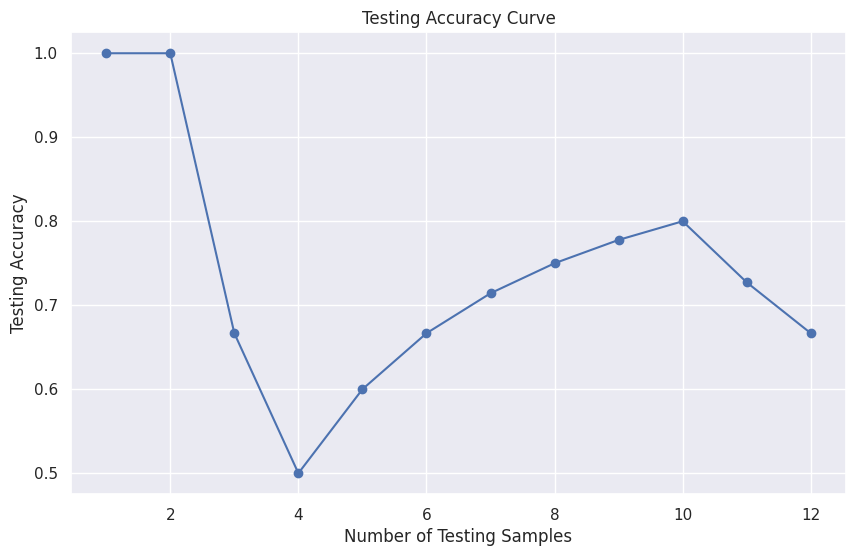

Log Loss: 0.47
Classification Report

              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.86      0.67      0.75         9

    accuracy                           0.67        12
   macro avg       0.63      0.67      0.62        12
weighted avg       0.74      0.67      0.69        12

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            2            1
Actual 1            3            6


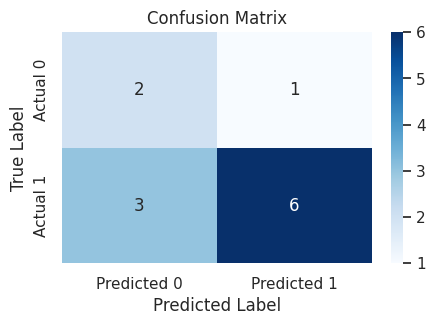


 ROC_AUC 0.81 



Outbreak Prediction Precentage  Predicted Label  True Label  \
0                            99.25                1           1   
1                            95.49                1           1   
2                            79.05                1           0   
3                            40.08                0           1   
4                            97.20                1           1   
5                            17.17                0           0   
6                            66.16                1           1   
7                            56.53                1           1   
8                            98.08                1           1   
9                            14.56                0           0   
10                           47.03                0           1   
11                           38.59                0           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [102]:
# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

testing_accuracies= []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(y_test) + 1):
    accuracy = accuracy_score(y_test[:i], y_pred[:i])
    testing_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test) + 1), testing_accuracies, marker='o')

plt.xlabel('Number of Testing Samples')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Curve')
plt.grid(True)
plt.show()

logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print('\n ROC_AUC',roc_auc,"\n")

# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df

In [103]:
#Testing with L1 regularization
#parameter tuning .
param_dist = {'C': [0.001, 0.01, 0.1, 1]}

model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=100,
    dual=False,
    class_weight=None,
    random_state=42,
    fit_intercept=True,
    multi_class='ovr',
    verbose=0
)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=4,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result ='C': 1
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'C': 1}


In [104]:
#parameter tuning. Set C = 1
param_dist = {'max_iter': randint(50,700)}

#Testing with L1 regularization
model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    dual=False,
    C=1,
    class_weight=None,
    random_state=42,
    fit_intercept=True,
    multi_class='ovr',
    verbose=0
)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=10,  # Number of random combinations to try
                                    scoring='accuracy',
                                    cv=5,  # Cross-validation folds
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result ='max_iter': 152
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'max_iter': 152}


In [105]:
#Testing with L1 regularization setting {'C': 0.1} ,{'max_iter': 152}
model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    dual=False,
    C=1,
    max_iter = 152,
    class_weight=None,
    random_state=42,
    fit_intercept=True,
    multi_class='ovr',
    verbose=0
)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

Accuracy: 0.67 

Log Loss: 0.47
Classification Report

              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.86      0.67      0.75         9

    accuracy                           0.67        12
   macro avg       0.63      0.67      0.62        12
weighted avg       0.74      0.67      0.69        12

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            2            1
Actual 1            3            6


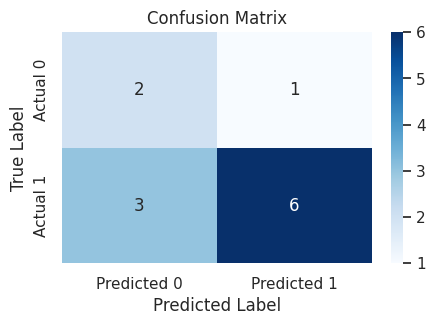

ROC_AUC 0.81 



Outbreak Prediction Precentage  Predicted Label  True Label  \
0                            98.06                1           1   
1                            93.26                1           1   
2                            71.23                1           0   
3                            40.40                0           1   
4                            94.48                1           1   
5                            20.84                0           0   
6                            62.39                1           1   
7                            50.05                1           1   
8                            95.92                1           1   
9                            18.88                0           0   
10                           45.96                0           1   
11                           38.58                0           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [106]:
# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

#accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy = np.round(accuracy, 2)
print("Accuracy:", accuracy,"\n")

logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print('ROC_AUC',roc_auc,"\n")

# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df

In [107]:
#Testing with L2 regularization
#parameter tuning testing C value
param_dist = {'C': [0.001, 0.01, 0.1, 1]}

model = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=100,
    dual=False,
    class_weight=None,
    random_state=42,
    fit_intercept=True,
    multi_class='ovr',
    verbose=0
)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=4,  # Number of random combinations to try
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result ='C': 0.1
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'C': 0.1}


In [108]:
#parameter tuning testing best Optimization algorithm
param_dist = {'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}

model = LogisticRegression(
    penalty='l2',
    max_iter=100,
    dual=False,
    class_weight=None,
    C=0.1,
    random_state=42,
    fit_intercept=True,
    multi_class='ovr',
    verbose=0
)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=4,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result ={'solver': 'lbfgs'}
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'solver': 'lbfgs'}


In [109]:
#parameter tuning testing best Optimization algorithm setting {'solver': 'lbfgs'}, C=0.1
param_dist = {'max_iter': randint(50,700)}

model = LogisticRegression(
    penalty='l2',
    C = 0.1,
    solver = 'lbfgs',
    dual=False,
    class_weight=None,
    random_state=42,
    fit_intercept=True,
    multi_class='ovr',
    verbose=0
)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=4,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result ='max_iter': 152
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'max_iter': 152}


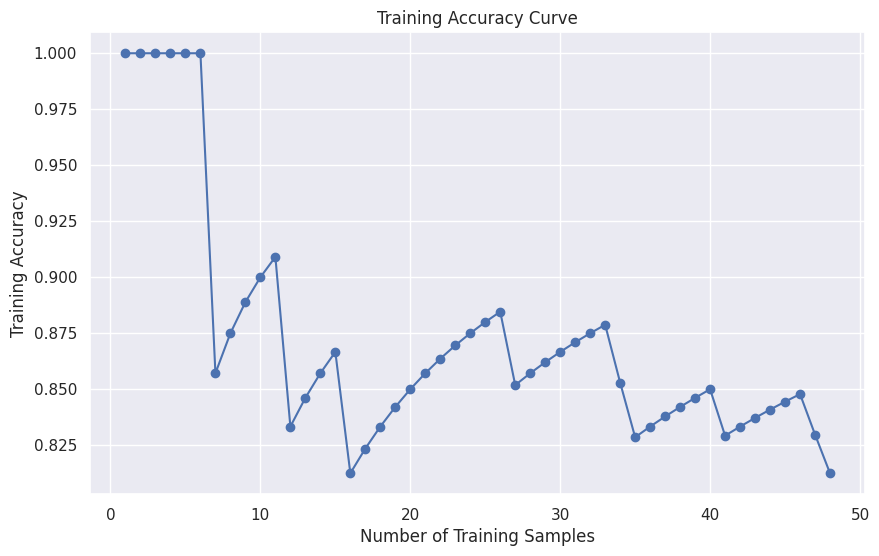

Training Accuracy 0.81


In [114]:
#Testing with L2 regularization setting {'C': 1} ,{'solver': 'lbfgs'},{'max_iter': 152}
model = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    dual=False,
    C=0.1,
    max_iter = 152,
    class_weight=None,
    random_state=42,
    fit_intercept=True,
    multi_class='ovr',
    verbose=0
)

# Initialize lists to store training accuracies
training_accuracies = []
# Train the model using the entire training set and calculate accuracy for the first i samples
for i in range(1, len(X_train_scaled) + 1):
    model.fit(X_train_scaled, y_train)  # Fit the model using the entire training set
    y_pred = model.predict(X_train_scaled[:i])
    accuracy = accuracy_score(y_train[:i], y_pred)
    training_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_scaled) + 1), training_accuracies, marker='o')

plt.xlabel('Number of Training Samples')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.show()
print('Training Accuracy',np.round(accuracy,2))
# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

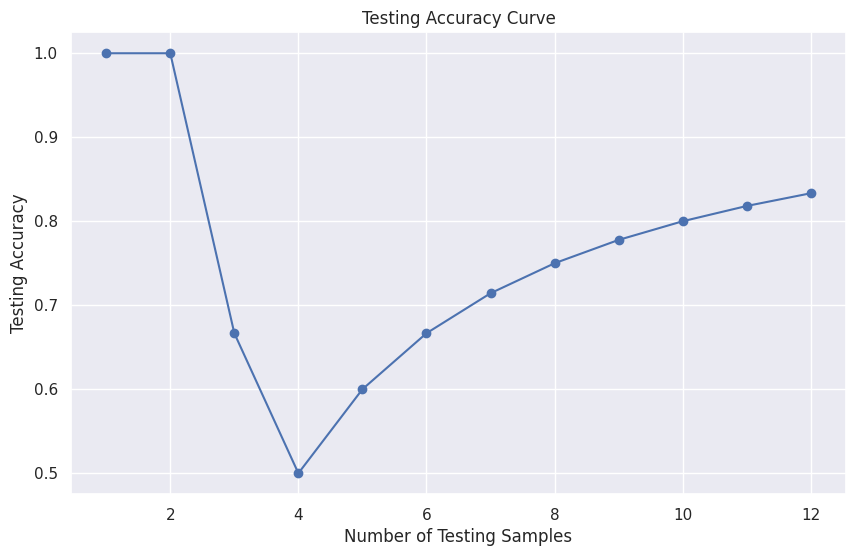

Log Loss: 0.44
Classification Report

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.89      0.89      0.89         9

    accuracy                           0.83        12
   macro avg       0.78      0.78      0.78        12
weighted avg       0.83      0.83      0.83        12

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            2            1
Actual 1            1            8


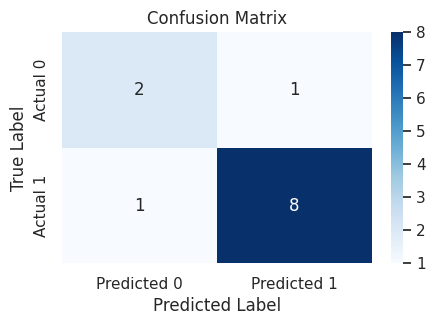

ROC_AUC 0.81 



Outbreak Prediction Precentage  Predicted Label  True Label  \
0                            97.27                1           1   
1                            90.56                1           1   
2                            76.69                1           0   
3                            48.31                0           1   
4                            93.01                1           1   
5                            30.55                0           0   
6                            64.67                1           1   
7                            61.66                1           1   
8                            94.71                1           1   
9                            27.65                0           0   
10                           54.19                1           1   
11                           51.24                1           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [115]:
# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

testing_accuracies= []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(y_test) + 1):
    accuracy = accuracy_score(y_test[:i], y_pred[:i])
    testing_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test) + 1), testing_accuracies, marker='o')

plt.xlabel('Number of Testing Samples')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Curve')
plt.grid(True)
plt.show()

logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print('ROC_AUC',roc_auc,"\n")

# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df

In [107]:
#-----------------------------------------------------------------------------------


In [116]:
# Load the dataset
#XGBClassifier
data = Total_df.copy()

# Create a binary target variable indicating whether the number of cases exceeds a threshold (e.g., 1000)
threshold = 3000
df["Exceeded Threshold"] = (df["Monthly cases"] > threshold).astype(int)

# Separate features (X) and the new binary target (y)
X = df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"]]
y = df["Exceeded Threshold"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle =True)


# Scale the data using StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

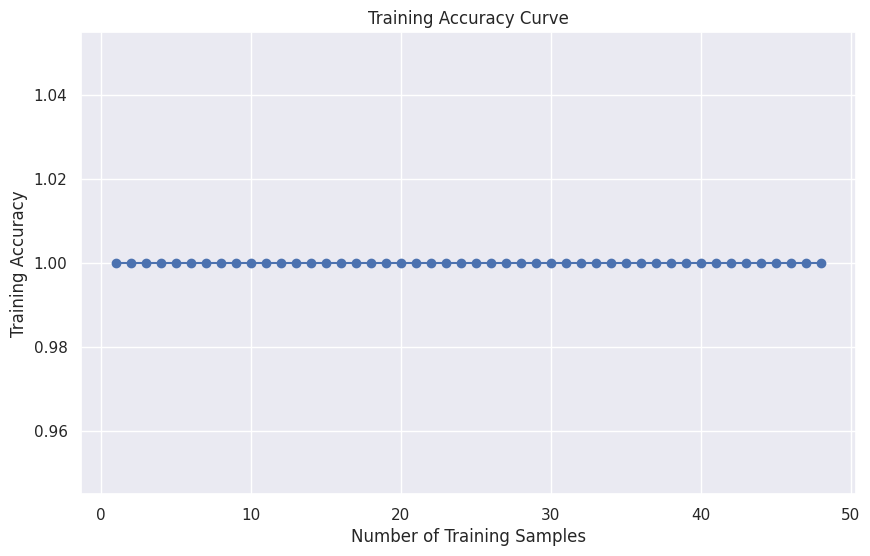

Training Accuracy 1.0


In [117]:
#xg boost
model = XGBClassifier()
# Initialize lists to store training accuracies
training_accuracies = []
# Train the model using the entire training set and calculate accuracy for the first i samples
for i in range(1, len(X_train_scaled) + 1):
    model.fit(X_train_scaled, y_train)  # Fit the model using the entire training set
    y_pred = model.predict(X_train_scaled[:i])
    accuracy = accuracy_score(y_train[:i], y_pred)
    training_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_scaled) + 1), training_accuracies, marker='o')

plt.xlabel('Number of Training Samples')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.show()
print('Training Accuracy',np.round(accuracy,2))


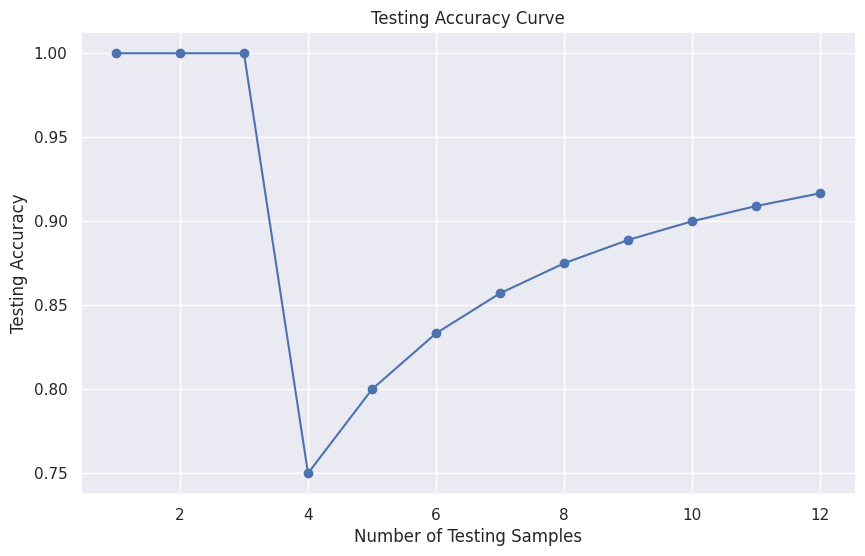

Log Loss: 0.42

Classification Report

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.89      0.94         9

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            1            8


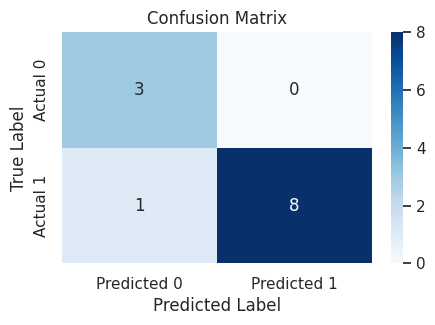

ROC_AUC 0.89 



Outbreak Prediction Precentage  Predicted Label  True Label  \
0                        97.879997                1           1   
1                        99.050003                1           1   
2                        17.860001                0           0   
3                         2.450000                0           1   
4                        97.879997                1           1   
5                        12.280000                0           0   
6                        92.650002                1           1   
7                        80.220001                1           1   
8                        97.879997                1           1   
9                        12.280000                0           0   
10                       81.620003                1           1   
11                       75.220001                1           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [118]:
# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

testing_accuracies= []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(y_test) + 1):
    accuracy = accuracy_score(y_test[:i], y_pred[:i])
    testing_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test) + 1), testing_accuracies, marker='o')

plt.xlabel('Number of Testing Samples')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Curve')
plt.grid(True)
plt.show()

logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

#run the classification
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, zero_division = 0))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print('ROC_AUC',roc_auc,"\n")


# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df


In [119]:
#Parameter tuning in xgboost
# testing C value
param_dist = {'booster': ['gblinear','gbtree','dart']}

model = XGBClassifier()
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=3,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result ={'booster': 'gbtree'}
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'booster': 'gbtree'}


In [120]:
#checking learning_rate
param_dist = {'learning_rate': [0.01,0.05,0.1,0.2,0.3]}

model = XGBClassifier(booster = 'gbtree')
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=5,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =0.2
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'learning_rate': 0.2}


In [121]:
#checking max_depth
param_dist = {'max_depth': randint(1,10)}

model = XGBClassifier(booster = 'gbtree',
                     learning_rate = 0.2)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=15,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =max depth = 7
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'max_depth': 7}


In [122]:
#checking subsample
param_dist = {'subsample': [0.5,0.6,0.7,0.8,0.9,1]}

model = XGBClassifier(booster = 'gbtree',
                     learning_rate = 0.2,
                     max_depth = 7)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=6,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =0.8
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'subsample': 0.8}


In [123]:
#checking tree_method
param_dist = {'tree_method': ['exact','auto']}

model = XGBClassifier(booster = 'gbtree',
                     learning_rate = 0.2,
                     max_depth = 7,
                     subsample = 0.8)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=2,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =exact
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'tree_method': 'exact'}


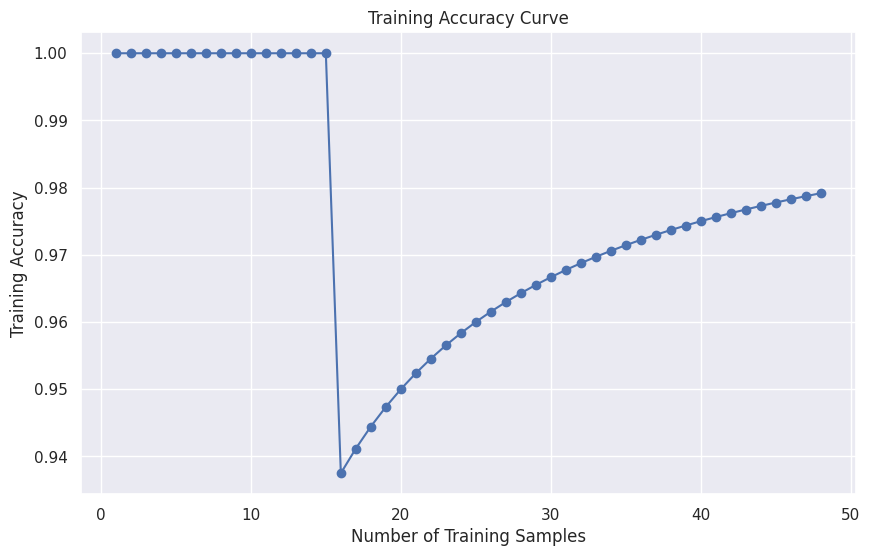

Training Accuracy:  0.98


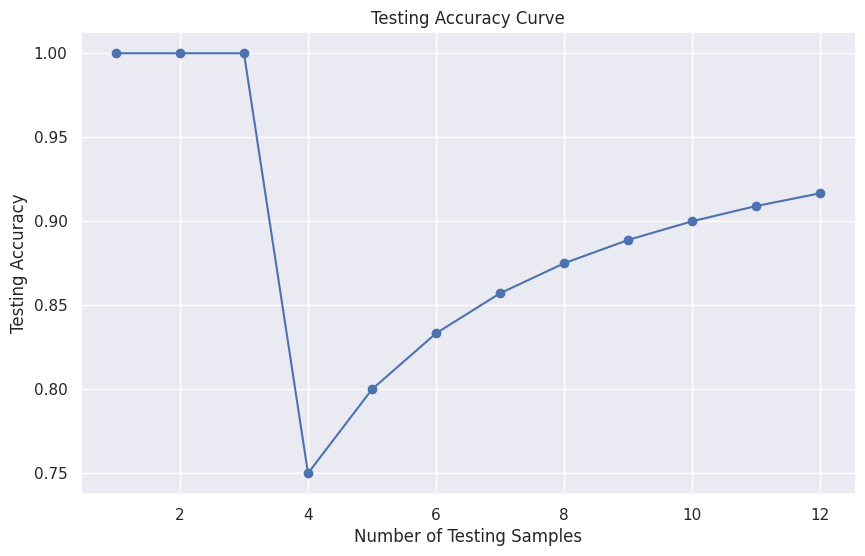

Log Loss: 0.44
Classification Report

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.89      0.94         9

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            1            8


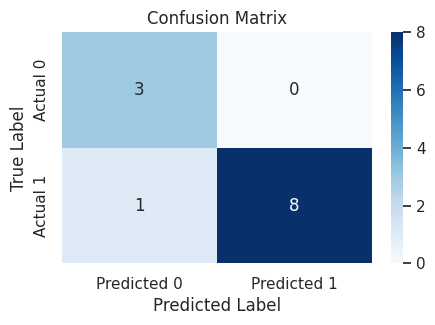

ROC_AUC 0.89 



Outbreak Prediction Precentage  Predicted Label  True Label  \
0                        97.930000                1           1   
1                        98.930000                1           1   
2                        27.690001                0           0   
3                         3.040000                0           1   
4                        97.930000                1           1   
5                        12.390000                0           0   
6                        90.889999                1           1   
7                        77.370003                1           1   
8                        97.930000                1           1   
9                        12.390000                0           0   
10                       72.050003                1           1   
11                       63.930000                1           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [124]:
#after setting the parameters

model = XGBClassifier(objective= 'binary:logistic',
                     booster = 'gbtree',
                     learning_rate = 0.2,
                     max_depth = 7,
                     subsample = 0.8,
                      tree_method = 'exact'
                     )
# Initialize lists to store training accuracies
training_accuracies = []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(X_train_scaled) + 1):
    model.fit(X_train_scaled, y_train)  # Fit the model using the entire training set
    y_pred = model.predict(X_train_scaled[:i])
    accuracy = accuracy_score(y_train[:i], y_pred)
    training_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_scaled) + 1), training_accuracies, marker='o')

plt.xlabel('Number of Training Samples')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.show()

print("Training Accuracy: ",np.round(accuracy,2))
# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

testing_accuracies= []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(y_test) + 1):
    accuracy = accuracy_score(y_test[:i], y_pred[:i])
    testing_accuracies.append(accuracy)

# Plot the testing accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test) + 1), testing_accuracies, marker='o')

plt.xlabel('Number of Testing Samples')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Curve')
plt.grid(True)
plt.show()

logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print('ROC_AUC',roc_auc,"\n")

# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df



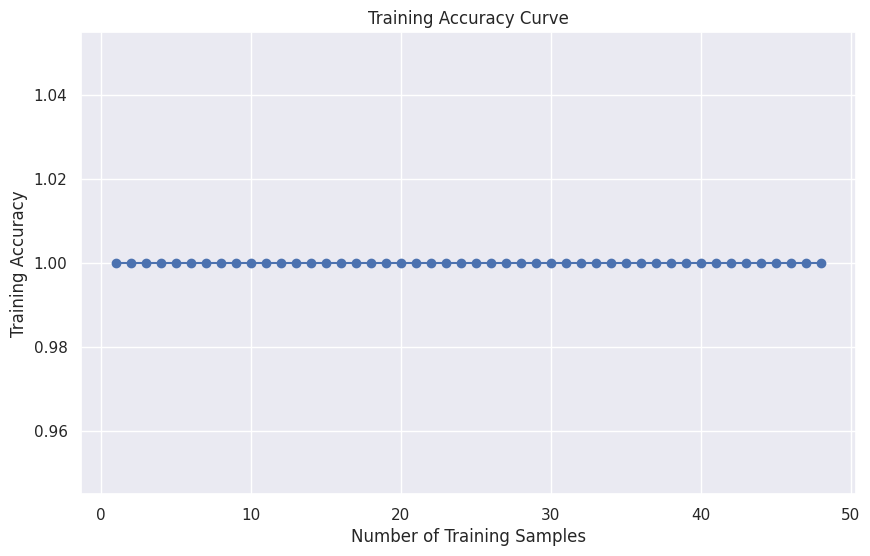

Training Accuracy:  1.0


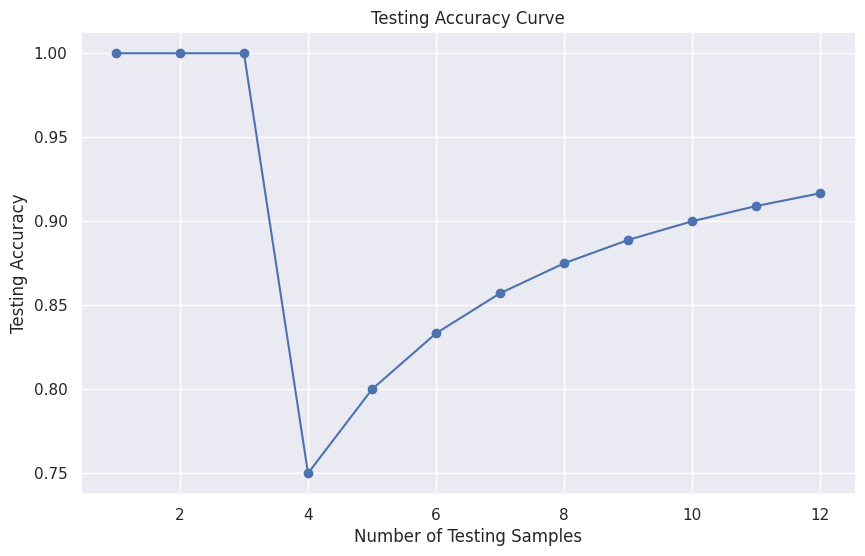

Log Loss: 0.31
Classification Report

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.89      0.94         9

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            1            8


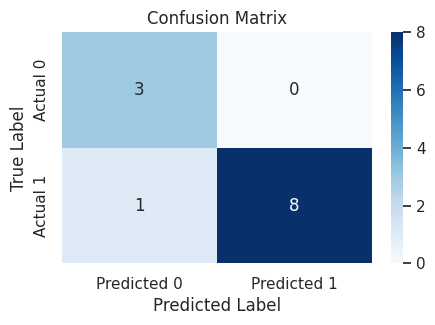

ROC_AUC 0.93 



Outbreak Prediction Precentage  Predicted Label  True Label  \
0                            100.0                1           1   
1                            100.0                1           1   
2                             29.0                0           0   
3                             20.0                0           1   
4                             92.0                1           1   
5                              6.0                0           0   
6                             93.0                1           1   
7                             69.0                1           1   
8                             92.0                1           1   
9                             21.0                0           0   
10                            64.0                1           1   
11                            68.0                1           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [125]:
#random forest
# Load the dataset
data = Total_df.copy()

# Create a binary target variable indicating whether the number of cases exceeds a threshold (e.g., 1000)
threshold = 3000
df["Exceeded Threshold"] = (df["Monthly cases"] > threshold).astype(int)

# Separate features (X) and the new binary target (y)
X = df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"]]
y = df["Exceeded Threshold"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle =True)

# Scale the data using StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier()

# Initialize lists to store training accuracies
training_accuracies = []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(X_train_scaled) + 1):
    model.fit(X_train_scaled, y_train)  # Fit the model using the entire training set
    y_pred = model.predict(X_train_scaled[:i])
    accuracy = accuracy_score(y_train[:i], y_pred)
    training_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_scaled) + 1), training_accuracies, marker='o')

plt.xlabel('Number of Training Samples')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.show()

print("Training Accuracy: ",np.round(accuracy,2))
# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

testing_accuracies= []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(y_test) + 1):
    accuracy = accuracy_score(y_test[:i], y_pred[:i])
    testing_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test) + 1), testing_accuracies, marker='o')

plt.xlabel('Number of Testing Samples')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Curve')
plt.grid(True)
plt.show()


logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print('ROC_AUC',roc_auc,"\n")

# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df


In [126]:
#checking the n_estimators
param_dist = {'n_estimators': randint(100,500)}

model = RandomForestClassifier()
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=10,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =202
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'n_estimators': 448}


In [127]:
#checking the criterion
param_dist = {'criterion': ['entropy','gini']}

model = RandomForestClassifier(n_estimators=202)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=2,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =entropy
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'criterion': 'entropy'}


In [128]:
#checking the max depth
param_dist = {'max_depth': randint(1,30)}

model = RandomForestClassifier(n_estimators=202,
                              criterion= 'entropy')
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=2,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =7
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'max_depth': 7}


In [129]:
#checking the min_samples_split
param_dist = {'min_samples_split': randint(2,20)}

model = RandomForestClassifier(n_estimators=202,
                              criterion= 'entropy',
                              max_depth = 7)
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=2,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =16
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'min_samples_split': 16}


In [130]:
#checking the  min_samples_leaf
param_dist = {'min_samples_leaf': randint(1,10)}

model = RandomForestClassifier(n_estimators=202,
                              criterion= 'entropy',
                              max_depth = 7,
                               min_samples_split = 16
                              )
Random_search_result = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=2,
                                    scoring='accuracy',
                                    cv=5,
                                    random_state=42
                                    )
Random_search_result.fit(X_train_scaled, y_train)

#Result =7
print("Best parameters:", Random_search_result.best_params_)

Best parameters: {'min_samples_leaf': 7}


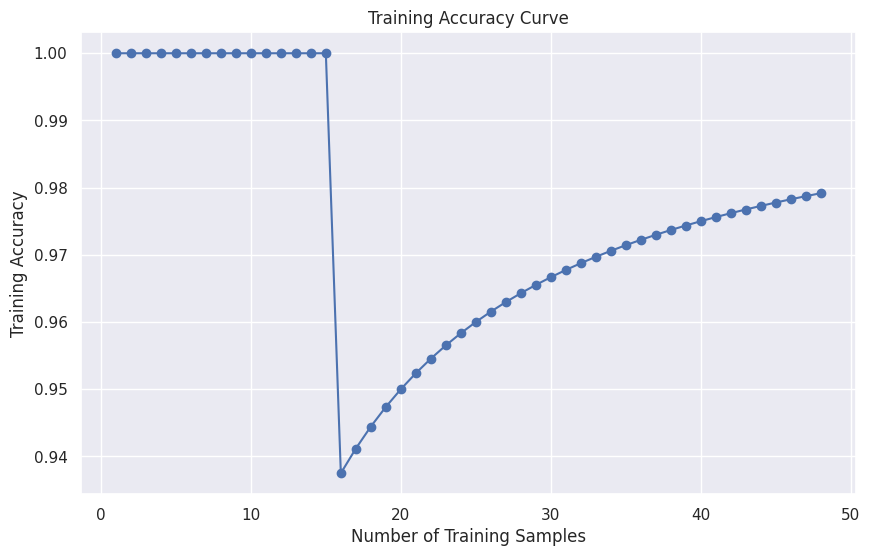

Training Accuracy:  0.98


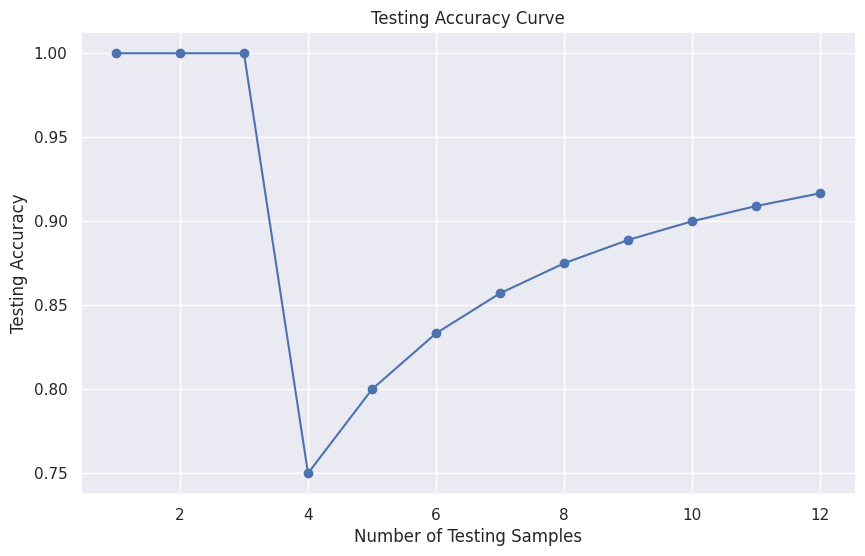

Log Loss: 0.45
Classification Report

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.89      0.94         9

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0            3            0
Actual 1            1            8


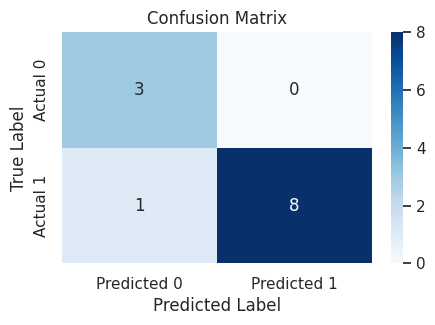

ROC_AUC 0.89 



Outbreak Prediction Precentage  Predicted Label  True Label  \
0                            97.90                1           1   
1                            99.74                1           1   
2                            30.04                0           0   
3                            13.80                0           1   
4                            97.90                1           1   
5                            37.11                0           0   
6                            83.73                1           1   
7                            56.01                1           1   
8                            97.90                1           1   
9                            35.14                0           0   
10                           52.23                1           1   
11                           51.35                1           1   

    Mean Temperature  Mean Precipitation  Max Temperature  Min Temperature  \
0              22.12               40.91            27.99            16.30   
1              25.48              210.86            31.35            19.66   
2              23.30               42.71            28.96            17.70   
3              25.80              128.76            31.11            20.55   
4              23.08               25.01            28.12            18.10   
5              26.55              182.54            32.20            20.92   
6              25.88              102.30            31.25            20.55   
7              23.48               22.07            29.09            17.94   
8              22.27               25.70            27.12            17.45   
9              26.47              195.97            31.63            21.34   
10             24.82              125.92            29.86            19.83   
11             24.32              177.13            30.02            18.68   

    Basic Drinking Water  Basic Sanitation  Open Defecation  
0              62.681800         28.205660        25.007650  
1              62.871608         28.646947        24.663992  
2              64.102230         31.412320        22.351090  
3              64.457003         32.229377        21.687175  
4              63.198431         29.353798        24.032275  
5              64.806410         33.050540        21.051330  
6              63.984845         31.142572        22.567735  
7              64.567480         32.501730        21.503710  
8              63.159660         29.264750        24.102890  
9              64.925875         33.324945        20.825140  
10             64.496422         32.320162        21.613407  
11             64.647123         32.684667        21.352917

In [131]:
model = RandomForestClassifier(n_estimators=202,
                              criterion= 'entropy',
                              max_depth = 7,
                              min_samples_split = 8,
                               min_samples_leaf =7,
                               random_state = 42,
                               bootstrap = False
                              )

# Initialize lists to store training accuracies
training_accuracies = []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(X_train_scaled) + 1):
    model.fit(X_train_scaled, y_train)  # Fit the model using the entire training set
    y_pred = model.predict(X_train_scaled[:i])
    accuracy = accuracy_score(y_train[:i], y_pred)
    training_accuracies.append(accuracy)

# Plot the training accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train_scaled) + 1), training_accuracies, marker='o')

plt.xlabel('Number of Training Samples')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)
plt.show()
print("Training Accuracy: ",np.round(accuracy,2))

# Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)

# Get the probability estimates for each class (0 and 1)
y_pred_probabilities = model.predict_proba(X_test_scaled)

testing_accuracies= []
# Train the model using the entire testing set and calculate accuracy for the first i samples
for i in range(1, len(y_test) + 1):
    accuracy = accuracy_score(y_test[:i], y_pred[:i])
    testing_accuracies.append(accuracy)

# Plot the testing accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test) + 1), testing_accuracies, marker='o')

plt.xlabel('Number of Testing Samples')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Curve')
plt.grid(True)
plt.show()


logloss = log_loss(y_test, y_pred_probabilities)
print("Log Loss:", np.round(logloss, 2) )

print('Classification Report\n')
# Print classification report
print(classification_report(y_test, y_pred, zero_division = 0))

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities[:, 1])
roc_auc = np.round(roc_auc_score(y_test, y_pred_probabilities[:, 1]),2)
print('ROC_AUC',roc_auc,"\n")

# Output
# Using the inverse_transform method of the scaler to get the original values of X_test_scaled
X_test_original = scaler.inverse_transform(X_test_scaled)

# Convert the predicted probabilities to a DataFrame
prob_df = pd.DataFrame(np.round((y_pred_probabilities[:, 1]*100),2), columns=['Outbreak Prediction Precentage'])

# Add the predicted labels to the DataFrame
prob_df['Predicted Label'] = y_pred

#Add the true labels to the Dataframe
y_test_reset = y_test.reset_index(drop=True)
prob_df['True Label'] = y_test_reset

# Add the original data points from X_test_original to the DataFrame
prob_df[["Mean Temperature", "Mean Precipitation", "Max Temperature", "Min Temperature",
         "Basic Drinking Water","Basic Sanitation","Open Defecation"
         ]] = pd.DataFrame(X_test_original, columns=["Mean Temperature", "Mean Precipitation", "Max Temperature",
                                                     "Min Temperature","Basic Drinking Water","Basic Sanitation","Open Defecation"])


# Display the resulting DataFrame
prob_df
